# **CO₂ Flux Prediction Project**

## 1. Introduction

In this notebook, we aim to develop and evaluate various machine learning models to predict CO₂ flux (in gm⁻² d⁻¹) using lithological, tectonic, and environmental variables, among others.

### 1.1 Main Objective
- **Primary Goal:** Build and compare different models (e.g., tree-based ensembles, linear methods, neural networks) to predict CO₂ flux from a given dataset of 868 measurements worldwide. These measurements include relevant continuous and categorical features.

### 1.2 Secondary Objective
- **Secondary Goal:** Select the best-performing and most interpretable model, then apply it to the Tamburello et al. (2018) database. This external database does not contain CO₂ flux measurements but does provide the necessary independent variables (locations and corresponding features). We will use the model to estimate CO₂ flux for these new data points.

### 1.3 Scope
- The main dataset includes 868 CO₂ flux measurements with associated features.  
- We will preprocess and clean the data, removing outliers or records lacking sufficient information.  
- The final model will be applied to the Tamburello dataset to predict CO₂ flux where it is not directly measured.

---

## 2. Importing Libraries

In [1]:
# =============================================================================
# Data Manipulation & Numerical Operations
# =============================================================================
import numpy as np
import pandas as pd

# =============================================================================
# Data Visualization
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================================
# Warnings
# =============================================================================
import warnings
warnings.filterwarnings("ignore")

# =============================================================================
# Scikit-learn Utilities: Model Selection & Evaluation
# =============================================================================
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    learning_curve
)
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error
)

# =============================================================================
# Regression Models
# =============================================================================
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    StackingRegressor
)
from sklearn.linear_model import ElasticNetCV, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# =============================================================================
# Data Encoding / Transformation
# =============================================================================
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    LabelEncoder
)
import category_encoders as ce

# =============================================================================
# Additional Modeling & Interpretability
# =============================================================================
import shap
from sklearn.inspection import PartialDependenceDisplay, permutation_importance

# =============================================================================
# Boosting Libraries
# =============================================================================
from xgboost import XGBRegressor

# =============================================================================
# Hyperparameter Optimization
# =============================================================================
from scipy.stats import randint, uniform

# =============================================================================
# End of Imports
# =============================================================================


## 3. Loading the Dataset

In [2]:
df = pd.read_csv("data/CO2_Flux_model_new.csv")

In [3]:
df.shape

(868, 30)

**Data Exclusion Rationale:**
- After exploratory checks, we determined that records with very high CO₂ flux (above 2000 gm⁻² d⁻¹) were sparse and lacked sufficient coverage in the dataset.
- Keeping extreme outliers with little to no complementary data could adversely affect the modeling process.

## 4. Data Exploration and Preprocessing

### 4.1 Dimensions and Overview

In [4]:
# Shape of the dataset
print("Dataset dimensions:", df.shape)

# Column names
print("Column names:", df.columns.tolist())

# Quick glance at the first few rows
df.head()

Dataset dimensions: (868, 30)
Column names: ['Longitude (x)', 'Latitude (y)', 'Flux (gm-2d-1)', 'Geothermal_Gradient_C_deg_km', 'Bouguer_Anomaly_mGal', 'Heat_Flow_mW_m2', 'Annual_Mean_Temperature_C', 'Soil_Organic_Carbon_ton_ha', 'Soil_pH_H2O', 'Elevation_m', 'faults_distance_km', 'geological_province_prov_type', 'mineralization_distance_km', 'mineralization_TipoMinera', 'volcano_distance_km', 'mineral_commodity_distance_km', 'Slip_type_general_Id', 'mineral_commodity_group', 'Available_Water_Storage_mm/m', 'Tree_Cover_Percentage', 'Porosity', 'Permeability_permafrost', 'PGA_Mean', 'Lithology', 'CO2_1000hPa', 'CO_1000hPa', 'Geopotential_1000hPa', 'Flux_CO2_GPP', 'Total_Column_CO2', 'Geopotential_Sup_Avg']


Longitude (x)  Latitude (y)  Flux (gm-2d-1)  Geothermal_Gradient_C_deg_km  \
0         102.30         29.10           93.84                     28.571070   
1         102.20         29.03          125.46                     28.571070   
2         102.20         28.90           74.59                     32.729389   
3         102.20         28.94           73.68                     31.710056   
4         102.25         28.92           79.31                     31.710056   

   Bouguer_Anomaly_mGal  Heat_Flow_mW_m2  Annual_Mean_Temperature_C  \
0            -205.61984        64.690002                   4.403472   
1            -227.75060        70.279999                   0.763889   
2            -201.12297        74.199997                   3.650695   
3            -195.34673        74.199997                   3.004167   
4            -242.01614        73.364998                   3.331945   

   Soil_Organic_Carbon_ton_ha  Soil_pH_H2O  Elevation_m  ...  Porosity  \
0                   72.708626         6.25    2350.8828  ...      0.01   
1                   81.654778         6.70    4032.7935  ...      0.01   
2                   74.057350         6.70    2873.9717  ...      0.22   
3                   78.911232         6.70    3091.8813  ...      0.01   
4                   76.603004         6.70    2901.5972  ...      0.01   

  Permeability_permafrost  PGA_Mean                Lithology  CO2_1000hPa  \
0                   -14.1  0.457723  Mixed sedimentary rocks     0.000682   
1                   -14.1  0.308835  Mixed sedimentary rocks     0.000663   
2                   -13.0  0.365298  Mixed sedimentary rocks     0.000668   
3                   -14.1  0.359317  Mixed sedimentary rocks     0.000668   
4                   -14.1  0.399901  Mixed sedimentary rocks     0.000671   

     CO_1000hPa  Geopotential_1000hPa  Flux_CO2_GPP  Total_Column_CO2  \
0  2.899415e-07           1903.183472  1.408404e-07        424.441864   
1  2.205228e-07           1674.980347  1.283715e-07        423.293427   
2  2.409077e-07           1586.967163  1.278420e-07        423.367371   
3  2.409077e-07           1586.967163  1.278420e-07        423.367371   
4  2.638654e-07           1633.263794  1.310809e-07        423.227112   

   Geopotential_Sup_Avg  
0          22298.542969  
1          33058.527344  
2          30758.531250  
3          30758.531250  
4          30216.531250  

[5 rows x 30 columns]

**Analysis:**
- We examine the number of rows and columns to understand the size of the dataset.
- The column list gives us an overview of the available features, including any target variable (Flux (gm-2d-1)).
- `df.head()` provides a preview of how data is structured.

### 4.2 General Information and Data Types

In [5]:
# Inspect data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Longitude (x)                  868 non-null    float64
 1   Latitude (y)                   868 non-null    float64
 2   Flux (gm-2d-1)                 868 non-null    float64
 3   Geothermal_Gradient_C_deg_km   868 non-null    float64
 4   Bouguer_Anomaly_mGal           868 non-null    float64
 5   Heat_Flow_mW_m2                868 non-null    float64
 6   Annual_Mean_Temperature_C      868 non-null    float64
 7   Soil_Organic_Carbon_ton_ha     868 non-null    float64
 8   Soil_pH_H2O                    868 non-null    float64
 9   Elevation_m                    868 non-null    float64
 10  faults_distance_km             868 non-null    float64
 11  geological_province_prov_type  868 non-null    object 
 12  mineralization_distance_km     868 non-null    flo

In [6]:
# Statistical summary of numerical variables
df.describe()

Longitude (x)  Latitude (y)  Flux (gm-2d-1)  \
count     868.000000    868.000000      868.000000   
mean      127.186087     29.072702      441.944778   
std       109.055256     20.879151     1136.867786   
min         7.316667    -39.420000        0.271479   
25%        22.016667     19.597514       18.670000   
50%       102.220000     36.405000       55.170000   
75%       259.093033     40.820000      280.821918   
max       357.866700     64.933333    18249.000000   

       Geothermal_Gradient_C_deg_km  Bouguer_Anomaly_mGal  Heat_Flow_mW_m2  \
count                    868.000000            868.000000       868.000000   
mean                      38.252070             46.375770        95.177711   
std                       15.651047            157.232471        41.338113   
min                       13.815114           -486.641970        33.730000   
25%                       27.889233            -29.150957        67.139999   
50%                       33.498169             82.052639        78.290001   
75%                       44.159059            143.637080       108.600000   
max                      103.526380            385.387300       245.539990   

       Annual_Mean_Temperature_C  Soil_Organic_Carbon_ton_ha  Soil_pH_H2O  \
count                 868.000000                  868.000000   868.000000   
mean                    7.602067                   59.646843     6.429674   
std                     4.236098                   43.468797     0.912318   
min                    -8.656944                    2.000000     4.200000   
25%                     4.348077                   40.088997     5.900000   
50%                     7.876999                   50.011261     6.400000   
75%                    11.415972                   67.577134     7.000000   
max                    19.603788                  344.125000     9.900000   

       Elevation_m  ...  Tree_Cover_Percentage    Porosity  \
count   868.000000  ...             868.000000  825.000000   
mean   1100.570377  ...              15.471005    0.148473   
std    1207.849759  ...              13.172172    0.085421   
min       0.000000  ...               0.000000    0.010000   
25%     102.804160  ...               4.666389    0.090000   
50%     671.174350  ...              12.107854    0.090000   
75%    1651.503400  ...              25.400000    0.220000   
max    5675.455600  ...              60.666667    0.280000   

       Permeability_permafrost    PGA_Mean  CO2_1000hPa    CO_1000hPa  \
count               835.000000  853.000000   868.000000  8.680000e+02   
mean                -13.178683    0.287205     0.000658  1.725857e-07   
std                   1.352926    0.170330     0.000013  6.879263e-08   
min                 -20.000000    0.000000     0.000624  6.424661e-08   
25%                 -13.000000    0.189012     0.000651  1.373493e-07   
50%                 -12.500000    0.234154     0.000655  1.499315e-07   
75%                 -12.500000    0.393485     0.000665  1.979197e-07   
max                 -10.900000    1.020010     0.000704  6.259530e-07   

       Geopotential_1000hPa  Flux_CO2_GPP  Total_Column_CO2  \
count            868.000000  8.680000e+02        868.000000   
mean            1441.346514  6.943458e-08        422.551711   
std              402.567472  1.597211e-07          0.937342   
min             -977.226685  0.000000e+00        420.317017   
25%             1302.797852  0.000000e+00        421.909912   
50%             1564.947144  0.000000e+00        422.211548   
75%             1718.535889  7.796708e-08        423.062164   
max             2011.038330  1.294593e-06        425.647919   

       Geopotential_Sup_Avg  
count            868.000000  
mean           10554.649909  
std            11681.749789  
min             -261.459045  
25%             1044.040161  
50%             5398.541992  
75%            17458.548828  
max            54070.519531  

[8 rows x 26 columns]

**Analysis:**
- `df.info()` shows the count of non-null values and the data type (object, float, int, etc.) for each column.
- `df.describe()` gives us quick descriptive statistics (mean, std, min, quartiles, max) for numerical features.
- This step helps to identify data type mismatches, missing values, or outliers in the numerical distribution.

## 4.3 Missing Data Analysis

In [7]:
# 4.3.1 Identify and Quantify Missing Values

# Count of missing values by column
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 Longitude (x)                     0
Latitude (y)                      0
Flux (gm-2d-1)                    0
Geothermal_Gradient_C_deg_km      0
Bouguer_Anomaly_mGal              0
Heat_Flow_mW_m2                   0
Annual_Mean_Temperature_C         0
Soil_Organic_Carbon_ton_ha        0
Soil_pH_H2O                       0
Elevation_m                       0
faults_distance_km                0
geological_province_prov_type     0
mineralization_distance_km        0
mineralization_TipoMinera         0
volcano_distance_km               0
mineral_commodity_distance_km     0
Slip_type_general_Id              0
mineral_commodity_group           0
Available_Water_Storage_mm/m     73
Tree_Cover_Percentage             0
Porosity                         43
Permeability_permafrost          33
PGA_Mean                         15
Lithology                         0
CO2_1000hPa                       0
CO_1000hPa                        0
Geopotential_1000hPa              0


In [8]:
# Percentage of missing values
missing_percentage = (df.isnull().sum() / len(df)) * 100
print("\nPercentage of missing values:\n", missing_percentage)


Percentage of missing values:
 Longitude (x)                    0.000000
Latitude (y)                     0.000000
Flux (gm-2d-1)                   0.000000
Geothermal_Gradient_C_deg_km     0.000000
Bouguer_Anomaly_mGal             0.000000
Heat_Flow_mW_m2                  0.000000
Annual_Mean_Temperature_C        0.000000
Soil_Organic_Carbon_ton_ha       0.000000
Soil_pH_H2O                      0.000000
Elevation_m                      0.000000
faults_distance_km               0.000000
geological_province_prov_type    0.000000
mineralization_distance_km       0.000000
mineralization_TipoMinera        0.000000
volcano_distance_km              0.000000
mineral_commodity_distance_km    0.000000
Slip_type_general_Id             0.000000
mineral_commodity_group          0.000000
Available_Water_Storage_mm/m     8.410138
Tree_Cover_Percentage            0.000000
Porosity                         4.953917
Permeability_permafrost          3.801843
PGA_Mean                         1.728111
Li

**Analysis:**
- We first count how many missing (null) entries there are in each column.
- Then we calculate the percentage of missing values relative to the total number of rows.
- This helps us decide whether to drop columns/rows or perform imputation (depending on the extent of missingness and the importance of each feature).

### 4.3.2 Imputing Missing Values

**Rationale for Median Imputation:**
The median is a robust measure of central tendency, less influenced by extreme outliers compared to the mean. When data are skewed or contain significant outliers, the median often provides a more representative midpoint. By imputing missing values with the median, we reduce the risk of introducing biases caused by extreme values, thereby potentially yielding more stable and reliable models.

In [9]:
# Use SimpleImputer with 'median' strategy to fill missing numeric values
from sklearn.impute import SimpleImputer

# Identify numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Create the imputer object
imputer = SimpleImputer(strategy='median')

# Apply imputation to numeric columns
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

**Outcome:**
- All numeric columns with missing values are now filled using the median of each respective column.
- This step helps ensure we retain as many data points as possible without discarding entire rows, which could reduce the dataset size unnecessarily.

## 4.4 Exploratory Data Analysis

### 4.4.1 Distribution of the Target Variable

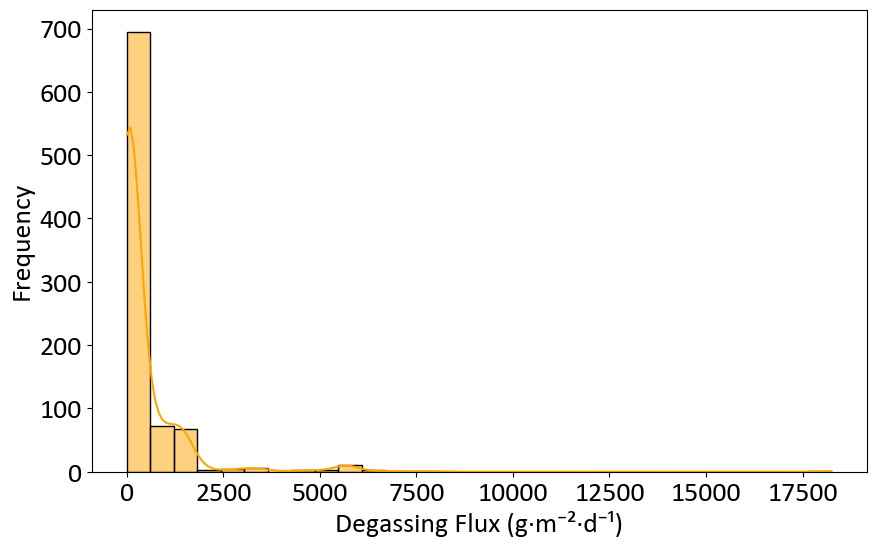

In [ ]:
# Plot the original target distribution
plt.rcParams["font.family"] = "Calibri"
plt.rcParams["font.size"] = 20
plt.figure(figsize=(10, 6))
sns.histplot(df['Flux (gm-2d-1)'], kde=True, bins=30, color="orange")
# plt.title("Distribution of CO₂ Degassing Flux")  
plt.xlabel("Degassing Flux (g·m⁻²·d⁻¹)")
plt.ylabel("Frequency")
plt.savefig("figures/figure_3a.png", dpi=300, bbox_inches="tight")
plt.show()

**Observations:**
- The target variable, **Flux (gm-2d-1)**, appears strongly right-skewed.
- Most data points are relatively low (below 1000 gm⁻²·d⁻¹), but there are some extreme outliers reaching beyond 5000 or even 17500.
- Such a skewed distribution can cause issues:
  - **Model Sensitivity to Outliers:** Linear models and SVMs can be heavily influenced by extreme values.
  - **Inflated Error Metrics:** Errors like RMSE (which squares residuals) heavily penalize large deviations.
  - **Distance-Based Methods (e.g., KNN):** Large distances may dominate when comparing 6000 vs. 1000.
  - **Heteroscedasticity Concerns:** Some models assume constant variance of errors, which might not hold here.

Although some extreme measurements could be valid, they can still pose modeling challenges. We decided to remove outliers above 2000 gm⁻²·d⁻¹ **after** visualizing the distribution, so we can justify the choice.

In [11]:
df = df[df["Flux (gm-2d-1)"] <= 2000]

### 4.4.2 Logarithmic Transformation

**Why Log Transform?**  
- The flux values are strictly positive, making them ideal candidates for a log transform.
- A log transform can reduce right-skewness and help many algorithms better capture the majority of the data distribution.
- It also diminishes the influence of extreme values, potentially improving regression performance and stabilizing variance.

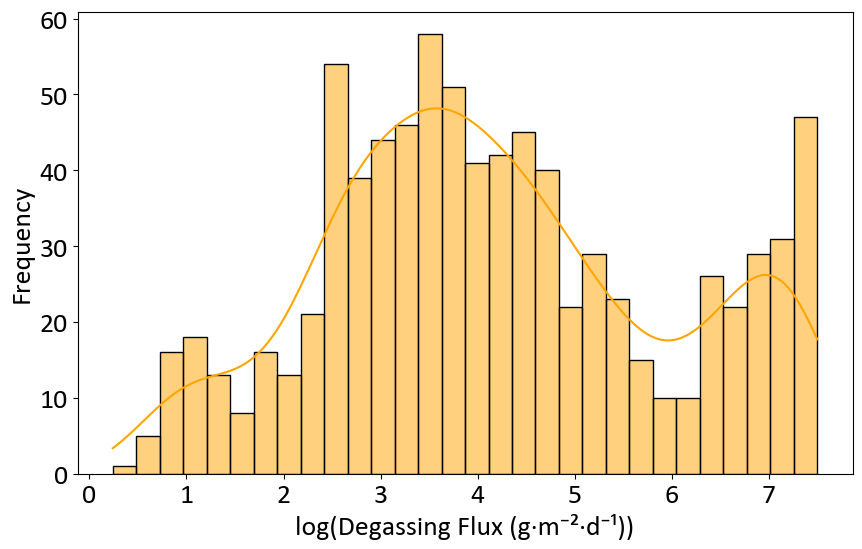

In [ ]:
# Create a new column with log-transformed Flux
df['Flux_log'] = np.log(df['Flux (gm-2d-1)'] + 1)  # +1 to avoid log(0)

# Plot the log-transformed target distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Flux_log'], kde=True, bins=30, color="orange")
# plt.title("Logarithmic Distribution of CO₂ Degassing Flux") 
plt.xlabel("log(Degassing Flux (g·m⁻²·d⁻¹))")
plt.ylabel("Frequency")
plt.savefig("figures/figure_3b.png", dpi=300, bbox_inches="tight")
plt.show()

**Observations on Log-Transformed Distribution:**
- The distribution is now **much less skewed**.
- Most values cluster around a central range, with fewer extreme tails.
- This transformation should help many machine learning models learn patterns more effectively and reduce the undue influence of outliers.
- We should still stay alert for possible **bimodality** or multimodal tendencies, which might suggest subpopulations in the data (e.g., different geological contexts).

### 4.4.3 Categorizing the Log-Transformed Flux (Optional)

In this case, the logarithm-transformed flow is segmented into qualitative bins (e.g., Low, Moderate, High) based on domain-specific thresholds, in order to perform an exploratory analysis of these ranges based on the explanatory variables.

In [ ]:
# Create log-based categories
df['Flux_log_range'] = pd.cut(
    df['Flux_log'],
    bins=[0, 2, 5, np.inf],  #
    labels=['Low', 'Moderate', 'High']
)


print(df['Flux_log_range'].value_counts())

# (Optional) Save the updated DataFrame
#df.to_csv("Flujo_log_range.csv", index=False)

Flux_log_range
Moderate    502
High        252
Low          81
Name: count, dtype: int64


## 4.5 Geophysical and Geothermal Variables

These variables relate to the Earth's internal properties, heat transfer, and geophysical anomalies that may be tied to degassing processes:

- **Heat_Flow_mW_m2**: Surface heat flux (mW/m²), directly related to the internal energy and geothermal activity of the Earth.  
- **Bouguer_Anomaly_mGal**: A gravity anomaly (mGal) that helps identify anomalous density distributions in the subsurface, potentially linked to fluid pathways or thermal anomalies.

### 4.5.1 Bouguer Anomaly (mGal)

<Figure size 1200x600 with 0 Axes>

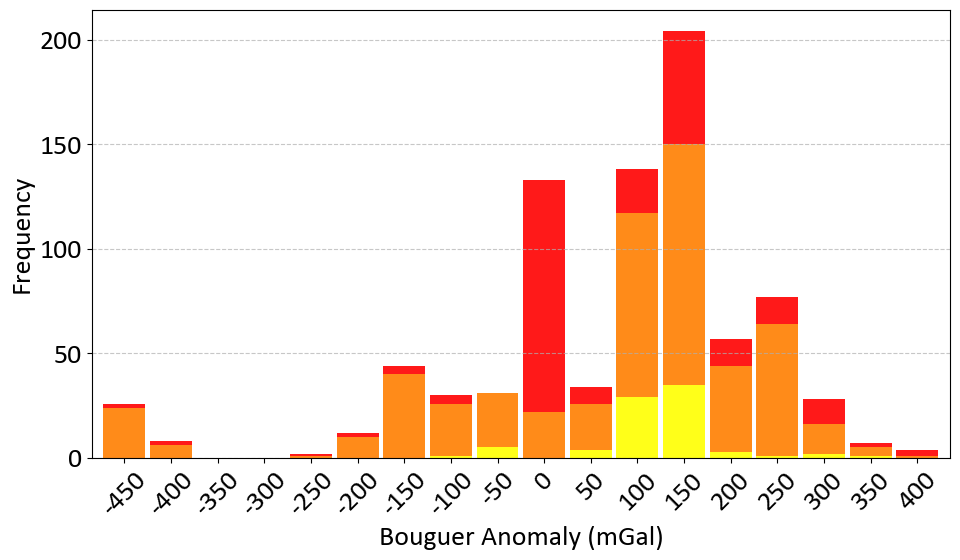

In [ ]:
def plot_bouguer_anomaly_distribution(df):
    """Generates a histogram of the Bouguer anomaly with 50 mGal intervals,
    showing the proportion of CO₂ flux without the descriptive statistics box."""

    # Define data for the 'Bouguer_Anomaly_mGal' variable
    bouguer_anomaly = df['Bouguer_Anomaly_mGal']

    # Define histogram bins for Bouguer anomaly
    bins_anomaly = np.arange(-500, 450, 50)

    # Group data by CO₂ flux and Bouguer anomaly
    grouped_data = df.groupby(pd.cut(df["Bouguer_Anomaly_mGal"], bins=bins_anomaly))["Flux_log_range"].value_counts().unstack().fillna(0)

    # Extract only final interval values for the X-axis
    tick_labels = [str(int(b)) for b in bins_anomaly[1:]]
    plt.rcParams["font.family"] = "Calibri"  
    plt.rcParams["font.size"] = 20 
    
    # Create figure
    plt.figure(figsize=(12, 6))
    orig_map=plt.cm.get_cmap('autumn') 
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))

    # Graph configuration
    plt.xlabel("Bouguer Anomaly (mGal)")
    plt.ylabel("Frequency")
    #plt.title("Bouguer Anomaly with Flux Proportion")  
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Adjust X-axis labels to show only final interval values
    ax.set_xticklabels(tick_labels, rotation=45)
    
    # Remove legend
    ax.get_legend().remove()
    #plt.legend(title="CO₂ Flux (g·m⁻²·d⁻¹)", bbox_to_anchor=(1.05, 1), loc="upper left")  
    
    plt.savefig("figures/figure_4a.png", dpi=300, bbox_inches="tight")
    
    # Show the graph
    plt.tight_layout()
    plt.show()

# Run function with dataset
plot_bouguer_anomaly_distribution(df)

**Observations:**
- The **Bouguer anomaly** is grouped in 50 mGal intervals, capturing both negative (potentially lower density) and positive (higher density) anomaly regions.
- Large negative anomalies may indicate zones of crustal thinning or significant fluid presence that could enable CO₂ flow.
- By stacking the flux categories, we can explore if certain anomaly ranges align with higher CO₂ flux occurrences.

### 4.5.2 Heat Flow (mW/m²)

<Figure size 1200x600 with 0 Axes>

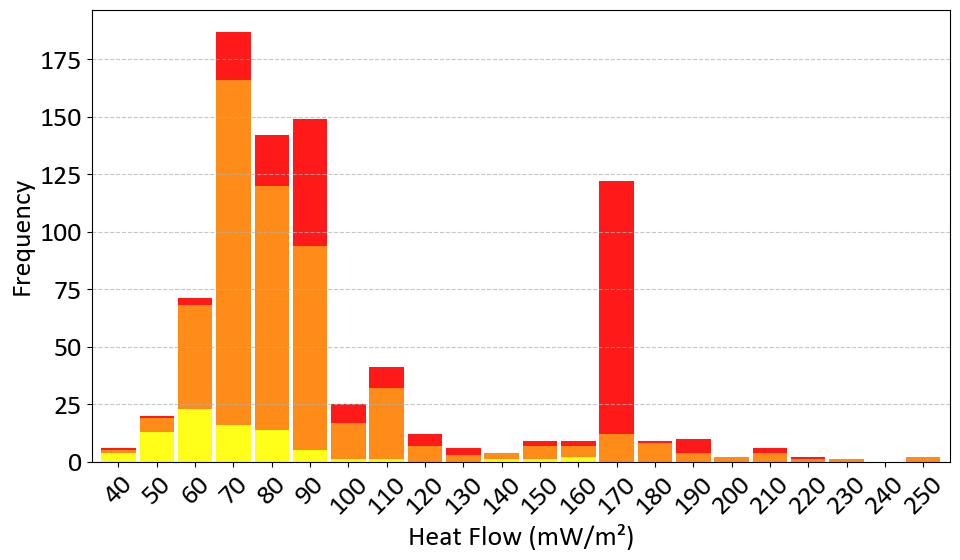

In [ ]:
def plot_heat_flow_distribution(df):
    """Generates a heat flow histogram with 10 mW/m² intervals,
    showing the proportion of CO₂ flux without the descriptive statistics box."""

    # Filter values within the range of interest
    heat_flow_values = df["Heat_Flow_mW_m2"]
    
    # Define histogram bins for heat flow
    bins_heat_flow = np.arange(30, 260, 10)

    # Group data by CO₂ flux and heat flow
    grouped_data = df.groupby(pd.cut(df["Heat_Flow_mW_m2"], bins=bins_heat_flow))["Flux_log_range"].value_counts().unstack().fillna(0)

    # Extract only final interval values for the X-axis
    tick_labels = [str(int(b)) for b in bins_heat_flow[1:]]
    
    # Configure graph font
    plt.rcParams["font.family"] = "Calibri" 
    plt.rcParams["font.size"] = 20  
    
    # Create figure
    plt.figure(figsize=(12, 6))
    orig_map=plt.cm.get_cmap('autumn') 
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))

    # Graph configuration
    plt.xlabel("Heat Flow (mW/m²)")
    plt.ylabel("Frequency")
    #plt.title("Heat Flow with Flux Proportion")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # Adjust X-axis labels to show only final interval values
    ax.set_xticklabels(tick_labels, rotation=0)
    plt.xticks(rotation=45)
 
    #plt.legend(title="CO₂ Flux (g·m⁻²·d⁻¹)", bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.get_legend().remove()
    plt.savefig("figures/figure_4b.png", dpi=300, bbox_inches="tight")
    
    # Show the graph
    plt.tight_layout()
    plt.show()

# Run function with dataset
plot_heat_flow_distribution(df)


**Observations:**
- This plot shows the distribution of samples across discrete heat-flow bins (30 to 250 mW/m²).
- Each bar is subdivided into **Low, Moderate, or High** CO₂ flux categories (based on `Flux_log_range`).
- Higher heat flow could indicate more intense geothermal activity, potentially correlated with CO₂ emissions.

## 4.6 Tectonic and Structural Variables

In this section, we explore variables related to fault proximity, fault type, geological provinces, mineralization distance, volcano distance, and other tectonic indicators. These features may have a direct influence on CO₂ flux emissions through subsurface pathways and geodynamic settings.

**Variables:**

- **faults_distance_km**: Distance to the nearest fault (km).  
- **Slip_type_general_Id**: General slip or movement type of the fault (e.g., Normal, Strike-slip, Reverse).   
- **mineralization_distance_km**: Distance to mineralized areas (often associated with tectonic structures).  
- **volcano_distance_km**: Distance to the nearest volcano, a proxy for volcanic/tectonic activity.  
- **PGA_Mean**: Mean Peak Ground Acceleration, an indicator often related to seismic hazard and tectonic activity.  
- **mineral_commodity_distance_km**: Distance to known mineral resources, which can be tied to certain tectonic or hydrothermal processes.


**Color Scheme:**
We defined a custom color palette for future bar charts:

In [16]:
#custom_colors = ['#fff888', '#ffa804', '#ff550b']

*(Note: The code below uses a reversed “autumn” colormap for the stacked bar plots. You can adapt it to your custom palette if desired.)*

### 4.6.1 Distance to Faults

<Figure size 1000x600 with 0 Axes>

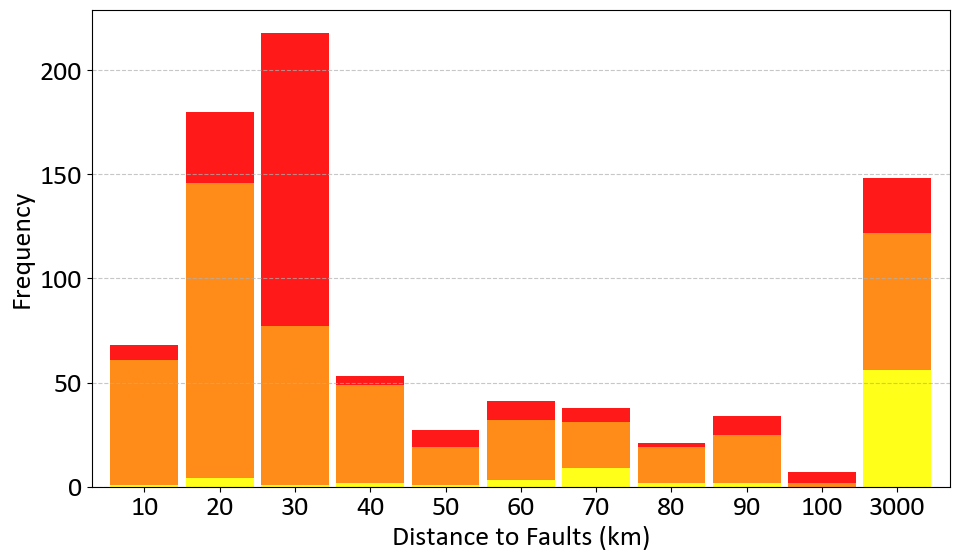

In [ ]:
def plot_faults_distance_histogram(df):
    """
    Generates a stacked bar chart showing the distribution of distance to active faults
    with the proportion of CO₂ flux in each category, using vertical bars.
    """

    
    bins = list(np.arange(0, 110, 10)) + [3000] 
    labels = [f"{int(bins[i+1])}" for i in range(len(bins) - 1)]  

    # Categorize fault distance
    df["Fault_Distance_Categories"] = pd.cut(
        df["faults_distance_km"], 
        bins=bins, 
        labels=labels, 
        include_lowest=True, 
        ordered=True
    )

    # Group data by CO₂ flux category
    grouped_data = df.groupby("Fault_Distance_Categories")["Flux_log_range"].value_counts().unstack().fillna(0)
    grouped_data = grouped_data.reindex(labels)  # Ensure numerical order

    # Configure font
    plt.rcParams["font.family"] = "Calibri"
    plt.rcParams["font.size"] = 20

    # Plot stacked bar chart
    plt.figure(figsize=(10, 6))
    orig_map = plt.cm.get_cmap('autumn') 
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, cmap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))

    # Configure axes and labels
    plt.xlabel("Distance to Faults (km)")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=0)
    ax.get_legend().remove()
    plt.savefig("figures/figure_5a.png", dpi=300, bbox_inches="tight")
    plt.tight_layout()
    plt.show()

# Run the function
plot_faults_distance_histogram(df)

**Observations:**
- The stacked bars show how many samples belong to each fault-distance bin, further subdivided by CO₂ flux categories (Low, Moderate, High).
- We might expect closer distances to faults to have higher flux if active faulting facilitates degassing.

#### 4.6.1.1 Fault Type (Slip_type_general_Id)

<Figure size 1000x600 with 0 Axes>

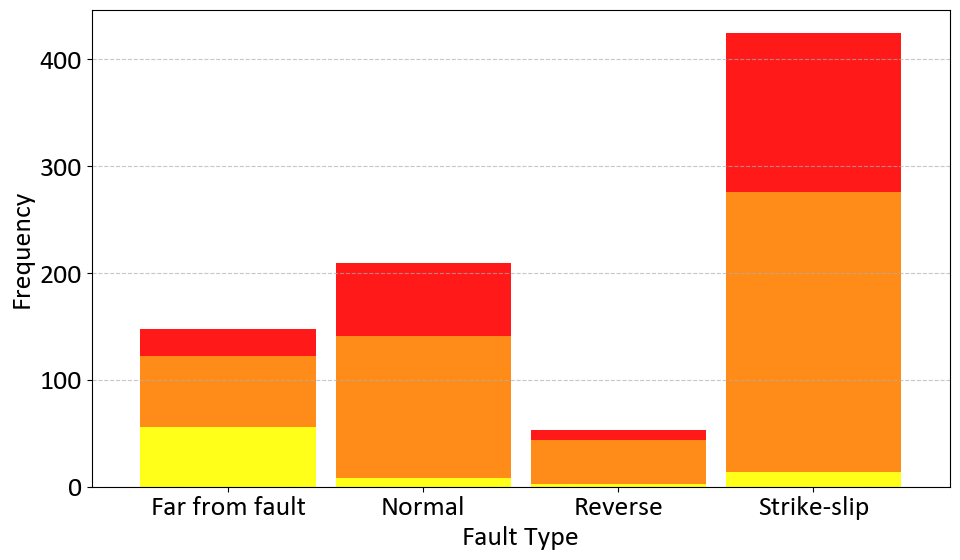

In [18]:
# Mark samples far from faults
df.loc[df['faults_distance_km'] > 100, 'Slip_type_general_Id'] = "Far from fault"

# Reclassify slip types
reclassification = {
    1:  "Normal",
    2:  "Strike-slip",
    3:  "Reverse",
    -1: "Strike-slip"
}
df['Slip_type_general_Id'] = df['Slip_type_general_Id'].replace(reclassification)

def plot_faults_type_histogram(df):
    """
    Generates a stacked bar chart showing the distribution of fault types
    with the proportion of CO₂ flux categories.
    """
    grouped_data = df.groupby("Slip_type_general_Id")["Flux_log_range"].value_counts().unstack().fillna(0)

    # Plot
    orig_map = plt.cm.get_cmap('autumn') 
    reversed_map = orig_map.reversed()
    plt.figure(figsize=(10, 6))
    ax = grouped_data.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))

    plt.xlabel("Fault Type")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=0)
    ax.get_legend().remove()
    plt.savefig("figures/figure_5b.png", dpi=300, bbox_inches="tight")
    plt.tight_layout()
    plt.show()

# Run the function
plot_faults_type_histogram(df)

**Observations:**
- By grouping samples by fault type, we can see if certain slip mechanisms correlate with higher or lower flux levels.
- We also included a “Far from fault” category for samples beyond 100 km from any known fault.

### 4.6.2 Peak Ground Acceleration (PGA)

<Figure size 1000x600 with 0 Axes>

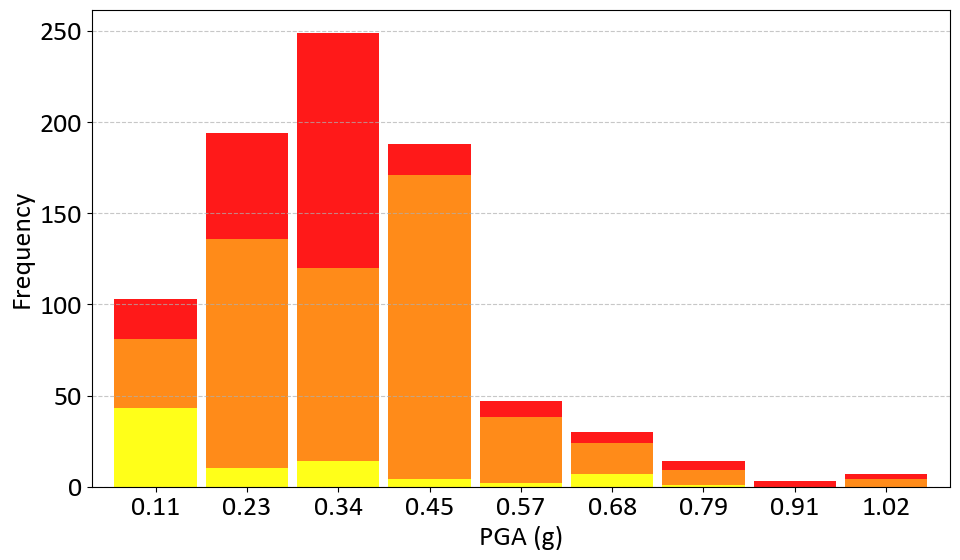

In [ ]:
def plot_pga_histogram(df):
    """Generates a stacked bar chart showing the distribution of PGA
    with the proportion of CO₂ flux in each category, maintaining numerical order and swapping axes."""

    # Define bins for PGA
    bins = np.linspace(df["PGA_Mean"].min(), df["PGA_Mean"].max(), num=10)
    labels = [f"{bins[i+1]:.2f}" for i in range(len(bins)-1)]  # Show only the final interval value

    # Categorize PGA into defined bins
    df["PGA_Category"] = pd.cut(df["PGA_Mean"], bins=bins, labels=labels, include_lowest=True)

    # Group data by CO₂ flux and PGA category
    grouped_data = df.groupby("PGA_Category")["Flux_log_range"].value_counts().unstack().fillna(0)

    # Maintain defined order of intervals
    grouped_data = grouped_data.reindex(labels)

    # Create figure with vertical bar chart 
    plt.figure(figsize=(10, 6))
    orig_map=plt.cm.get_cmap('autumn') 
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))

    # Graph configuration with swapped axes:
    plt.xlabel("PGA (g)")  
    plt.ylabel("Frequency")  
    #plt.title("PGA with Flux Proportion")
    plt.grid(axis='y', linestyle='--', alpha=0.7)  
    plt.xticks(rotation=0)
    #plt.legend(title="CO₂ Flux (g·m⁻²·d⁻¹)", bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.get_legend().remove()
    plt.savefig("figures/figure_5c.png", dpi=300, bbox_inches="tight")
    # Show the graph
    plt.tight_layout()
    plt.show()

# Run function with dataset
plot_pga_histogram(df)


**Observations:**
- Higher PGA could suggest more seismically active areas, which might correlate with active degassing pathways.
- This visualization checks if certain PGA ranges correspond to higher or lower flux categories.

### 4.6.3 Mineral Commodity Distance

<Figure size 1000x600 with 0 Axes>

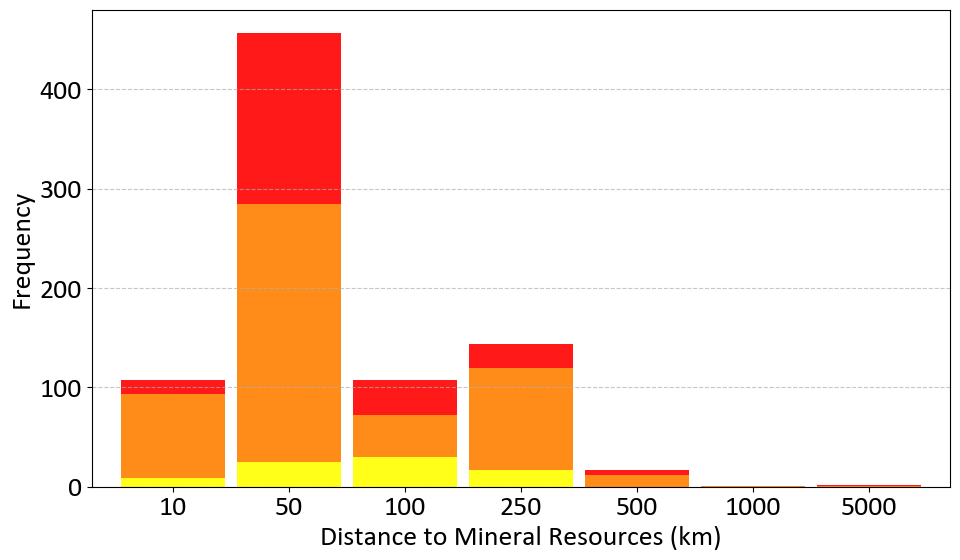

In [ ]:
def plot_mineral_commodity_distance_histogram(df):
    """Generates a stacked bar chart showing the distribution of distance to mineral resources
    with the proportion of CO₂ flux in each category."""

    # Define bins for distance to mineral resources
    bins = [0, 10, 50, 100, 250, 500, 1000, 5000]
    labels = [f"{int(bins[i+1])}" for i in range(len(bins)-1)]  

    # Categorize distance to mineral resources into defined bins
    df["Mineral_Commodity_Distance_Categories"] = pd.cut(
        df["mineral_commodity_distance_km"], 
        bins=bins, 
        labels=labels, 
        include_lowest=True, 
        ordered=True
    )

    # Group data by CO₂ flux and mineral resource distance category
    grouped_data = df.groupby("Mineral_Commodity_Distance_Categories")["Flux_log_range"].value_counts().unstack().fillna(0)

    # Maintain numerical order of categories
    grouped_data = grouped_data.reindex(labels)

    # Create figure with stacked bar chart
    plt.figure(figsize=(10, 6))
    orig_map = plt.cm.get_cmap('autumn')
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))

    # Graph configuration
    plt.xlabel("Distance to Mineral Resources (km)")
    plt.ylabel("Frequency")
    #plt.title("Distance to Mineral Resources with CO₂ Flux Proportion")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=0)
    
    # Adjust legend
    #plt.legend(title="CO₂ Flux (g·m⁻²·d⁻¹)", bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.get_legend().remove()
    # Save the image
    plt.savefig("figures/figure_5d.png", dpi=300, bbox_inches="tight")

    # Show the graph
    plt.tight_layout()
    plt.show()

# Run function with dataset if available
plot_mineral_commodity_distance_histogram(df)

**Observations:**
- Mineral resources areas sometimes coincide with structural weaknesses or hydrothermal systems that can facilitate CO₂ release.
- This chart helps us see if proximity to mineralization resource correlates with higher flux categories.

### 4.6.4 Distance to Mineralizations

<Figure size 1000x600 with 0 Axes>

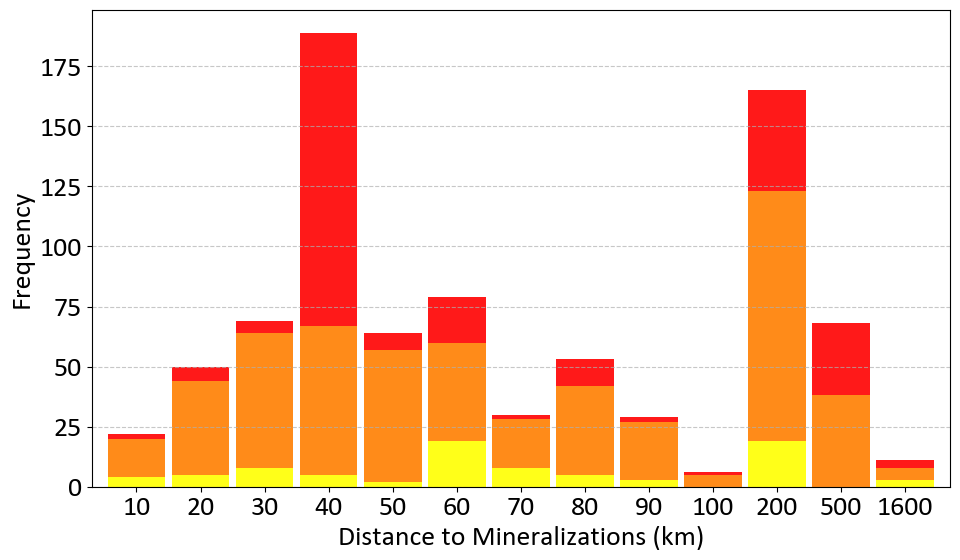

In [ ]:
def plot_mineralization_distance_histogram(df):
    """Generates a stacked bar chart showing the distribution of distance to mineralizations
    with the proportion of CO₂ flux in each category, with swapped axes."""

    # Define bins for distance to mineralizations
    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500, 1600]
    labels = [f"{int(bins[i+1])}" for i in range(len(bins)-1)]  

    # Categorize distance to mineralizations into defined bins
    df["Mineralization_Distance_Categories"] = pd.cut(
        df["mineralization_distance_km"], 
        bins=bins, 
        labels=labels, 
        include_lowest=True, 
        ordered=True
    )

    # Group data by CO₂ flux and mineralization distance category
    grouped_data = df.groupby("Mineralization_Distance_Categories")["Flux_log_range"].value_counts().unstack().fillna(0)

    # Maintain numerical order of categories
    grouped_data = grouped_data.reindex(labels)

    # Create figure with vertical bar chart (swapped axes)
    plt.figure(figsize=(10, 6))
    orig_map=plt.cm.get_cmap('autumn') 
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))

    # Graph configuration with swapped axes:
    plt.xlabel("Distance to Mineralizations (km)")  
    plt.ylabel("Frequency")                         
    #plt.title("Distance to Nearest Mineralization with Flux Proportion")
    plt.grid(axis='y', linestyle='--', alpha=0.7)      
    plt.xticks(rotation=0)
    #plt.legend(title="CO₂ Flux (g·m⁻²·d⁻¹)", bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.get_legend().remove()
    plt.savefig("figures/figure_5e.png", dpi=300, bbox_inches="tight")
    # Show graph
    plt.tight_layout()
    plt.show()

# Run function with dataset
plot_mineralization_distance_histogram(df)

**Observations:**
- Similar to **mineral resources**, proximity to Mineralization could reflect hydrothermal or tectonic conditions favorable to CO₂ migration.

### 4.6.5 Distance to Volcanoes


<Figure size 1000x600 with 0 Axes>

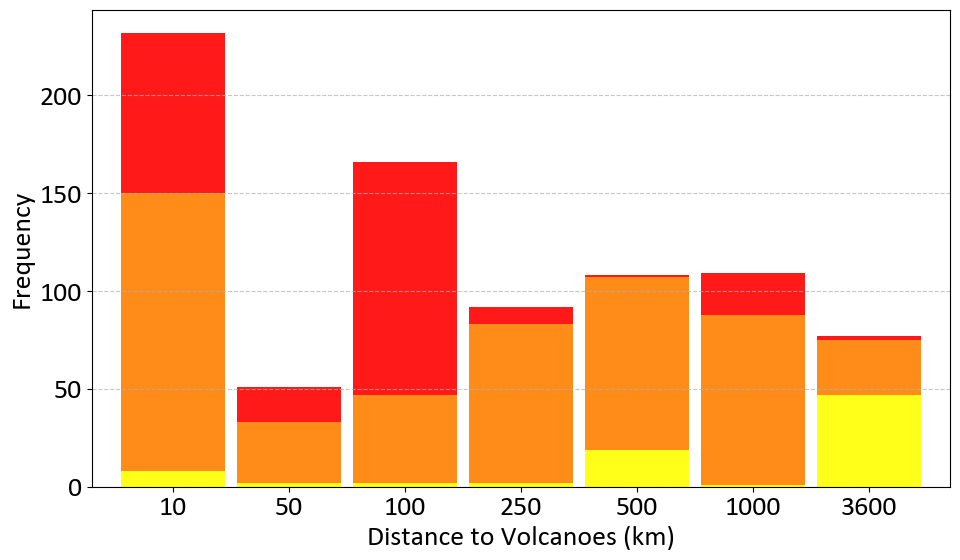

In [ ]:
def plot_volcano_distance_histogram(df):
    """Generates a stacked bar chart showing the distribution of distance to volcanoes
    with the proportion of CO₂ flux in each category, with swapped axes."""

    # Define bins for distance to volcanoes
    bins = [0, 10, 50, 100, 250, 500, 1000, 3600]
    labels = [f"{int(bins[i+1])}" for i in range(len(bins)-1)]  

    # Categorize distance to volcanoes into defined bins
    df["Volcano_Distance_Categories"] = pd.cut(
        df["volcano_distance_km"], 
        bins=bins, 
        labels=labels, 
        include_lowest=True, 
        ordered=True
    )

    # Group data by CO₂ flux and volcano distance category
    grouped_data = df.groupby("Volcano_Distance_Categories")["Flux_log_range"].value_counts().unstack().fillna(0)

    # Maintain numerical order of categories
    grouped_data = grouped_data.reindex(labels)

    # Create figure with vertical bar chart (swapped axes)
    plt.figure(figsize=(10, 6))
    orig_map=plt.cm.get_cmap('autumn') 
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))

    # Graph configuration with swapped axes:
    plt.xlabel("Distance to Volcanoes (km)")  
    plt.ylabel("Frequency")                 
    #plt.title("Distance to Nearest Volcano with Flux Proportion")
    plt.grid(axis='y', linestyle='--', alpha=0.7)  
    plt.xticks(rotation=0)
    # Adjust legend to avoid overlap
    #plt.legend(title="CO₂ Flux (g·m⁻²·d⁻¹)", bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.get_legend().remove()
    plt.savefig("figures/figure_5f.png", dpi=300, bbox_inches="tight")
    # Show the graph
    plt.tight_layout()
    plt.show()

# Run function with dataset
plot_volcano_distance_histogram(df)


**Observations:**
- Volcanic activity is a known contributor to CO₂ outgassing.
- Observing distance bins to volcanoes and the flux distribution can hint at whether volcanic proximity strongly influences CO₂ flux levels.

## Key Findings (Tectonic & Structural Variables)

1. **Faults and Slip Type:** Preliminary results may suggest higher flux in proximity to faults or certain slip types.
2. **PGA:** A measure of seismic risk that may or may not correlate strongly with degassing processes.
3. **Mineralization & Mineral Commodities:** Could be proxy indicators of crustal permeability and hydrothermal processes.  
4. **Volcano Distance:** Notable impact if many high-flux points lie near active volcanoes.  



## 4.7 Geological Variables

In this section, we examine key geological variables that may influence or correlate with CO₂ flux. These include permeability, porosity, water storage capacity, lithology, and geological province. Each variable can affect subsurface fluid flow, potentially impacting degassing processes and measured CO₂ emissions.


### 4.7.1 Permeability

<Figure size 1000x600 with 0 Axes>

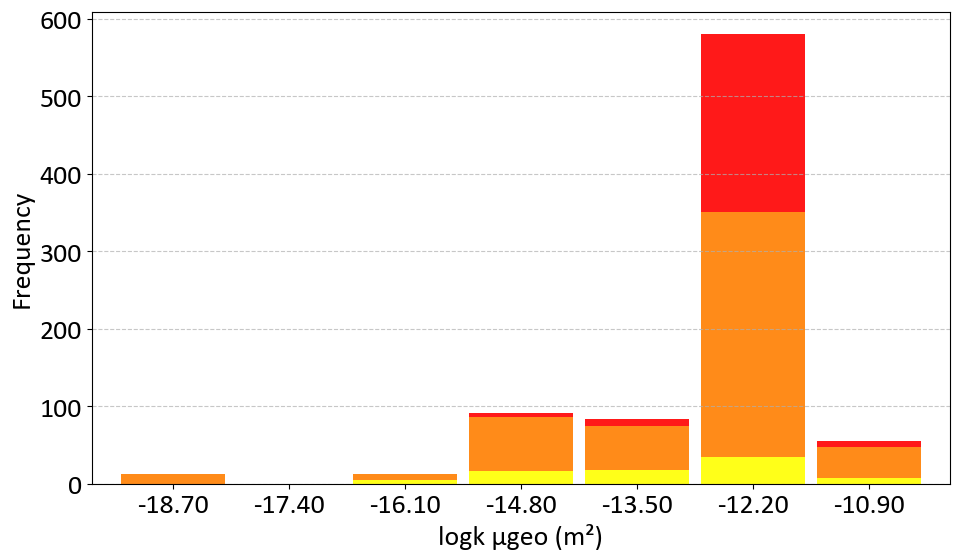

In [ ]:
def plot_permeability_histogram(df):
    """Generates a stacked bar chart showing the distribution of permeability
    with the proportion of CO₂ flux in each category, swapping axes."""

    # Check if the column exists
    if "Permeability_permafrost" not in df.columns:
        print("Error: The column 'Permeability_permafrost' is not in the DataFrame.")
        return

    # Define bins based on the actual data range
    permeability_min = df["Permeability_permafrost"].min()
    permeability_max = df["Permeability_permafrost"].max()
    
    bins = np.linspace(permeability_min, permeability_max, num=8)  
    labels = [f"{bins[i+1]:.2f}" for i in range(len(bins)-1)]  

    # Categorize permeability into defined bins
    df["Permeability_Category"] = pd.cut(df["Permeability_permafrost"], bins=bins, labels=labels, include_lowest=True)

    # Check if there are data points within the bins
    if df["Permeability_Category"].isna().all():
        print("Error: No values in 'Permeability_permafrost' fall within the defined bins.")
        return

    # Group data by CO₂ flux and permeability category
    grouped_data = df.groupby("Permeability_Category")["Flux_log_range"].value_counts().unstack().fillna(0)

    # Ensure permeability values remain in numerical order
    grouped_data = grouped_data.reindex(labels)

    # Create figure with vertical bar chart 
    plt.figure(figsize=(10, 6))
    orig_map=plt.cm.get_cmap('autumn') 
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))

    # Graph configuration with swapped axes:
    plt.xlabel("logk μgeo (m²)")  
    plt.ylabel("Frequency")  
    #plt.title("Permeability with Flux Proportion")  
    plt.grid(axis='y', linestyle='--', alpha=0.7)  
    plt.xticks(rotation=0)
    
    # Remove legend
    ax.get_legend().remove()
    #plt.legend(title="CO₂ Flux (g·m⁻²·d⁻¹)", bbox_to_anchor=(1.05, 1), loc="upper left") 
    
    
    plt.savefig("figures/figure_6a.png", dpi=300, bbox_inches="tight")
    
    # Show the graph
    plt.tight_layout()
    plt.show()

# Run function with dataset
plot_permeability_histogram(df)


**Observations:**
- Permeability can strongly influence how fluids (including CO₂) move through the subsurface.
- We bin `Permeability_permafrost` into discrete ranges and stack them by flux categories (**Low, Moderate, High**) to see if higher permeability might coincide with increased CO₂ flux.

### 4.7.2 Porosity

<Figure size 1000x600 with 0 Axes>

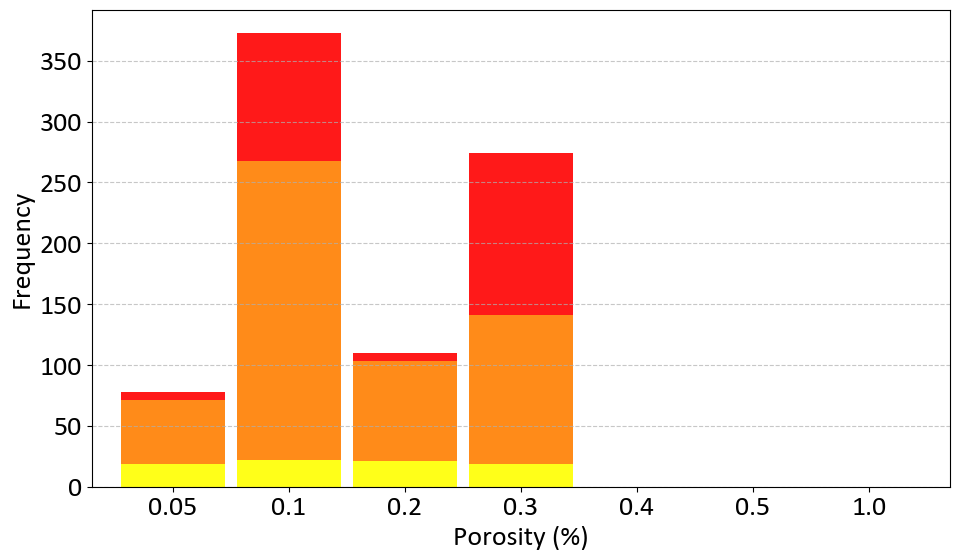

In [ ]:
def plot_porosity_histogram(df):
    """Generates a stacked bar chart showing the distribution of porosity
    with the proportion of CO₂ flux in each category, swapping axes."""

    # Define bins for porosity
    bins = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
    labels = [f"{bins[i+1]}" for i in range(len(bins)-1)]  

    # Categorize porosity into defined bins
    df["Porosity_Category"] = pd.cut(df["Porosity"], bins=bins, labels=labels, include_lowest=True)

    # Group data by CO₂ flux and porosity category
    grouped_data = df.groupby("Porosity_Category")["Flux_log_range"].value_counts().unstack().fillna(0)

    # Maintain defined interval order
    grouped_data = grouped_data.reindex(labels)

    # Create figure with vertical bar chart 
    plt.figure(figsize=(10, 6))
    orig_map=plt.cm.get_cmap('autumn') 
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))

    # Graph configuration with swapped axes:
    plt.xlabel("Porosity (%)")  
    plt.ylabel("Frequency")  
    #plt.title("Porosity with Flux Proportion")  
    plt.grid(axis='y', linestyle='--', alpha=0.7)  
    plt.xticks(rotation=0)
    
    # Remove legend
    ax.get_legend().remove()
    #plt.legend(title="CO₂ Flux (g·m⁻²·d⁻¹)", bbox_to_anchor=(1.05, 1), loc="upper left") 
    
    
    plt.savefig("figures/figure_6b.png", dpi=300, bbox_inches="tight")
    
    # Show the graph
    plt.tight_layout()
    plt.show()

# Run function with dataset
plot_porosity_histogram(df)


**Observations:**
- Porosity represents the void space within rock or soil. High porosity could potentially store more fluids, influencing CO₂ accumulation or flow.
- This stacked histogram allows us to see how porosity levels might align with different CO₂ flux ranges.

### 4.7.3 Available Water Storage

<Figure size 1000x600 with 0 Axes>

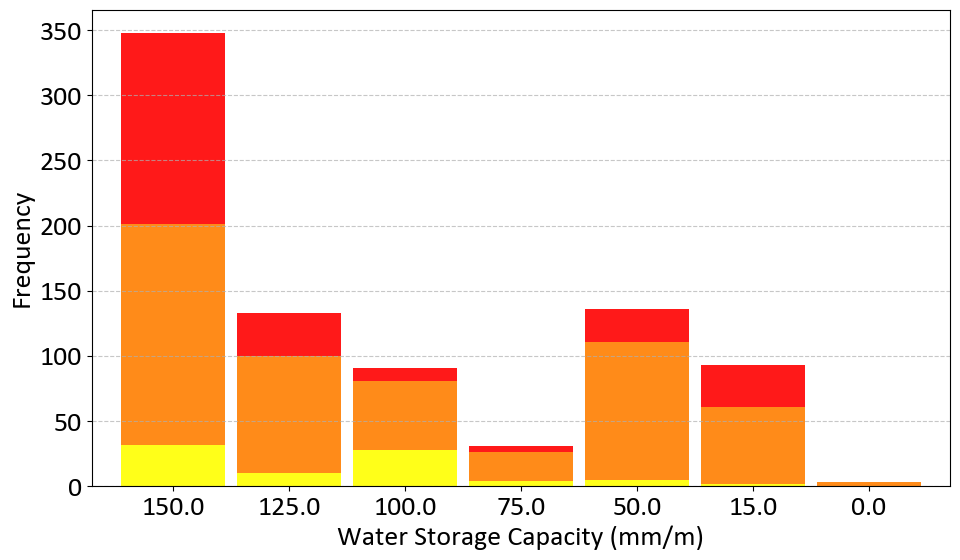

In [ ]:
def plot_available_water_storage(df):
    """Generates a bar chart of soil water storage capacity with CO₂ flux proportion,
    swapping axes."""

    # Group data by CO₂ flux and water storage category
    grouped_data = df.groupby("Available_Water_Storage_mm/m")["Flux_log_range"].value_counts().unstack().fillna(0)

    # Sort categories in the correct order
    ordered_labels = [150, 125, 100, 75, 50, 15, 0]
    grouped_data = grouped_data.loc[ordered_labels]

    # Create figure with vertical bar chart 
    plt.figure(figsize=(10, 6))
    orig_map=plt.cm.get_cmap('autumn') 
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))

    # Graph configuration with swapped axes:
    plt.xlabel("Water Storage Capacity (mm/m)")  
    plt.ylabel("Frequency")  
    #plt.title("Soil Water Storage Capacity with Flux Proportion")  
    plt.grid(axis='y', linestyle='--', alpha=0.7)  
    plt.xticks(rotation=0)
    
    # Remove legend
    ax.get_legend().remove()
    #plt.legend(title="CO₂ Flux (g·m⁻²·d⁻¹)", bbox_to_anchor=(1.05, 1), loc="upper left")  
    
    
    plt.savefig("figures/figure_6c.png", dpi=300, bbox_inches="tight")
    
    # Show the graph
    plt.tight_layout()
    plt.show()

# Run function with dataset
plot_available_water_storage(df)



**Observations:**
- Soil water storage can affect both microbial activity and gas transport in near-surface environments.
- Seeing how flux categories distribute across different storage capacities may reveal if wetter or drier soils have higher CO₂ emissions.

### 4.7.4 Lithology

<Figure size 1200x600 with 0 Axes>

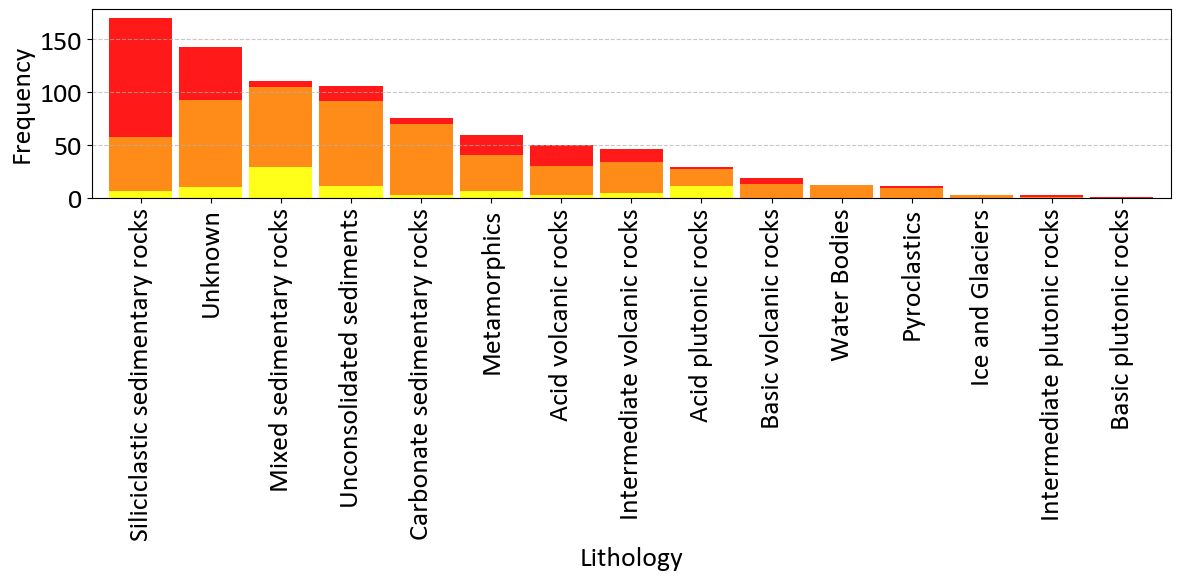

In [ ]:
def plot_lithology_histogram(df):
    """Generates a stacked bar chart showing the distribution of lithology
    with the proportion of CO₂ flux in each category."""

    # Group data by CO₂ flux and lithology
    grouped_data = df.groupby("Lithology")["Flux_log_range"].value_counts().unstack().fillna(0)

    # Sort by total number of records in each lithology
    grouped_data = grouped_data.loc[grouped_data.sum(axis=1).sort_values(ascending=False).index]

    # Create figure with stacked bar chart
    plt.figure(figsize=(12, 6))
    orig_map = plt.cm.get_cmap('autumn')
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.9, alpha=0.9, figsize=(12, 6))
    
    # Graph configuration
    plt.xlabel("Lithology")
    plt.ylabel("Frequency")
    #plt.title("Lithology Distribution with Flux Proportion")  
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=90)
    plt.rcParams["font.family"] = "Calibri" 
    plt.rcParams["font.size"] = 13  
    
    # Remove legend
    ax.get_legend().remove()
    #plt.legend(title="CO₂ Flux (g·m⁻²·d⁻¹)", bbox_to_anchor=(1.05, 1), loc="upper left")  

    
    plt.savefig("figures/figure_6d.png", dpi=300, bbox_inches="tight")

    # Show the graph
    plt.tight_layout()
    plt.show()

# Run function with dataset if available
plot_lithology_histogram(df)

**Observations:**
- Rock type can significantly influence porosity, permeability, and fluid flow pathways.
- This plot can highlight which lithologies correlate with higher degassing rates.

### 4.7.5 Geological Provinces

<Figure size 1200x700 with 0 Axes>

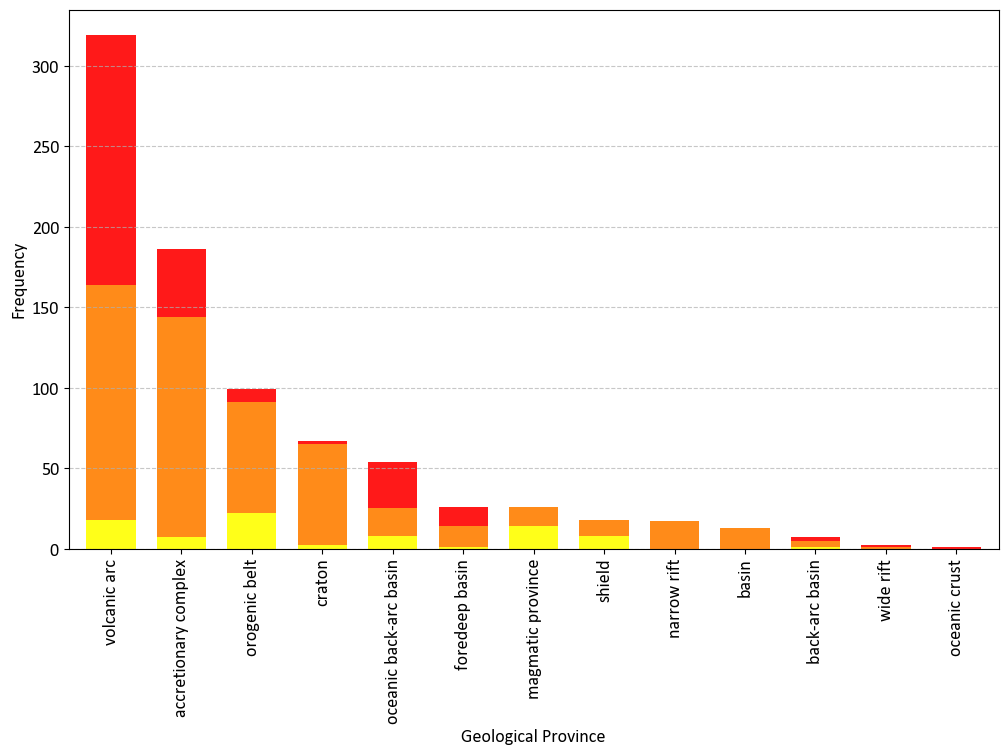

In [ ]:
def plot_geological_province_flux_proportion(df, category_column, flux_column, title):
    """Generates a stacked bar chart showing the total count and the proportion of CO₂ flux in each geological province category,
    ordered from highest to lowest frequency, with swapped axes."""
    
    plt.figure(figsize=(12, 7))

    # Obtain the number of points in each category-flux combination
    flux_counts = df.groupby(category_column)["Flux_log_range"].value_counts().unstack().fillna(0)

    # Sort data in descending order of total frequency
    flux_counts = flux_counts.loc[flux_counts.sum(axis=1).sort_values(ascending=False).index]

    # Create vertical stacked bar chart (swapped axes)
    orig_map=plt.cm.get_cmap('autumn') 
    reversed_map = orig_map.reversed()
    ax = flux_counts.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.7, alpha=0.9, figsize=(12, 7))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # Labels and title (with swapped axes)
    plt.xlabel("Geological Province")
    plt.ylabel("Frequency")
    #plt.title(title)
    plt.xticks(rotation=90)
    #plt.legend(title="CO₂ Flux (g·m⁻²·d⁻¹)", bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.get_legend().remove()
    plt.savefig("figures/figure_6e.png", dpi=300, bbox_inches="tight")
    
    
    plt.show()

# Apply the function to geological_province_prov_type with descending order
plot_geological_province_flux_proportion(df, 'geological_province_prov_type', "Flux (g·m⁻²·d⁻¹)", 
                                         "Geological Province with Flux Proportion")


**Observations:**
- Each bar represents a geological province subdivided by CO₂ flux categories.
- Some provinces may be more tectonically active, more permeable, or otherwise predisposed to higher CO₂ emissions.

## Key Findings for Geological Variables

1. **Permeability & Porosity**: Both parameters significantly govern fluid flow in the subsurface. High permeability or porosity can facilitate CO₂ migration.
2. **Available Water Storage**: Soil moisture and water capacity might influence microbial activity or fluid pathways, potentially affecting measured flux.
3. **Lithology**: Different rock types exhibit variable porosity, permeability, and geochemical properties that can shape degassing processes.
4. **Geological Provinces**: Distinct geologic settings may exhibit contrasting emission patterns, especially if volcanism, tectonics, or hydrothermal systems are involved.


## 4.8 Environmental Variables

In this section, we explore several environmental variables that may influence or correlate with CO₂ flux, such as soil pH, tree cover, soil organic carbon, temperature, and atmospheric CO₂ concentrations. These factors can affect biological activity, chemical reactions, and CO₂ exchange between the surface and the atmosphere.

### 4.8.1 Soil pH

<Figure size 1000x600 with 0 Axes>

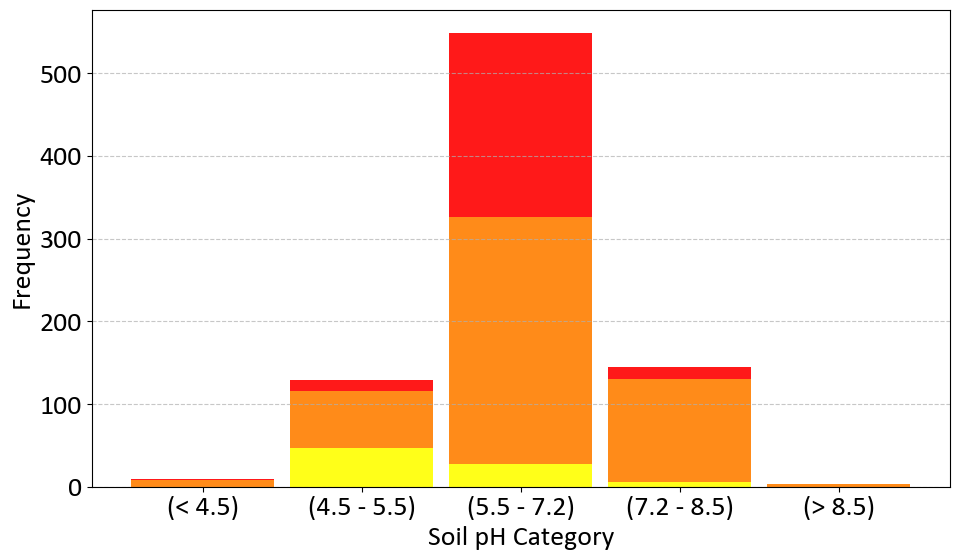

In [ ]:
def plot_soil_ph_categories(df):
    """Generates a categorized bar chart of soil pH, showing the proportion of CO₂ flux without the descriptive statistics box."""

    # Create pH categories
    categories = pd.cut(df["Soil_pH_H2O"], 
                        bins=[0, 4.5, 5.5, 7.2, 8.5, 10], 
                        labels=["(< 4.5)", "(4.5 - 5.5)", "(5.5 - 7.2)", 
                                "(7.2 - 8.5)", "(> 8.5)"])

    # Add categories to the DataFrame
    df["Soil_pH_Category"] = categories

    # Group data by CO₂ flux and soil pH category
    grouped_data = df.groupby("Soil_pH_Category")["Flux_log_range"].value_counts().unstack().fillna(0)

    # Sort pH categories in the correct order
    category_order = ["(< 4.5)", "(4.5 - 5.5)", "(5.5 - 7.2)", 
                      "(7.2 - 8.5)", "(> 8.5)"]

    grouped_data = grouped_data.loc[category_order]
    plt.rcParams["font.family"] = "Calibri"  
    plt.rcParams["font.size"] = 20  
    
    # Create figure
    plt.figure(figsize=(10, 6))
    orig_map=plt.cm.get_cmap('autumn') 
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))

    # Graph configuration
    plt.xlabel("Soil pH Category")
    plt.xticks(rotation=0)
    plt.ylabel("Frequency")
    #plt.title("Soil pH with Flux Proportion")  
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Remove legend
    ax.get_legend().remove()
    #plt.legend(title="CO₂ Flux (g·m⁻²·d⁻¹)", bbox_to_anchor=(1.05, 1), loc="upper left") 
    

    plt.savefig("figures/figure_7a.png", dpi=300, bbox_inches="tight")
    
    # Show the graph
    plt.tight_layout()
    plt.show()

# Run function with dataset
plot_soil_ph_categories(df)

**Observations:**
- Soil pH can influence microbial activity and chemical speciation, potentially affecting CO₂ production or consumption.
- This stacked chart shows whether more acidic or alkaline soils align with higher or lower CO₂ flux.

### 4.8.2 Tree Cover Percentage

<Figure size 1000x600 with 0 Axes>

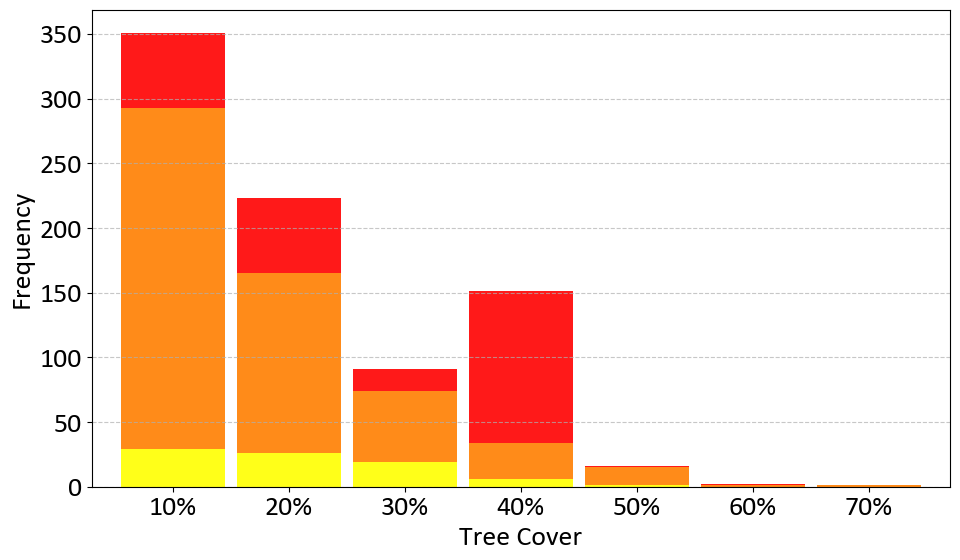

In [ ]:
def plot_tree_cover_histogram(df):
    """Generates a stacked bar chart showing the distribution of tree cover
    with the proportion of CO₂ flux in each category, swapping axes."""

    # Define bins for tree cover
    bins = [0, 10, 20, 30, 40, 50, 60, 70]
    labels = [f"{bins[i+1]}%" for i in range(len(bins)-1)]  

    # Categorize tree cover into defined bins
    df["Tree_Cover_Category"] = pd.cut(df["Tree_Cover_Percentage"], bins=bins, labels=labels, include_lowest=True)

    # Group data by CO₂ flux and tree cover category
    grouped_data = df.groupby("Tree_Cover_Category")["Flux_log_range"].value_counts().unstack().fillna(0)

    # Ensure values remain in numerical order rather than frequency order
    grouped_data = grouped_data.reindex(labels)  

    # Create figure with vertical bar chart 
    plt.figure(figsize=(10, 6))
    orig_map=plt.cm.get_cmap('autumn') 
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))

    # Graph configuration with swapped axes:
    plt.xlabel("Tree Cover")  
    plt.ylabel("Frequency")  
    #plt.title("Tree Cover with Flux Proportion")  
    plt.grid(axis='y', linestyle='--', alpha=0.7)  
    plt.xticks(rotation=0)
    
    # Remove legend
    ax.get_legend().remove()
    #plt.legend(title="CO₂ Flux (g·m⁻²·d⁻¹)", bbox_to_anchor=(1.05, 1), loc="upper left")  
    
    
    plt.savefig("figures/figure_7b.png", dpi=300, bbox_inches="tight")
    
    # Show the graph
    plt.tight_layout()
    plt.show()

# Run function with dataset
plot_tree_cover_histogram(df)


**Observations:**
- Vegetation cover can impact soil respiration and microclimate conditions.
- This chart indicates whether areas with higher or lower tree cover exhibit distinct CO₂ flux patterns.

### 4.8.3 Soil Organic Carbon (SOC)

<Figure size 1200x600 with 0 Axes>

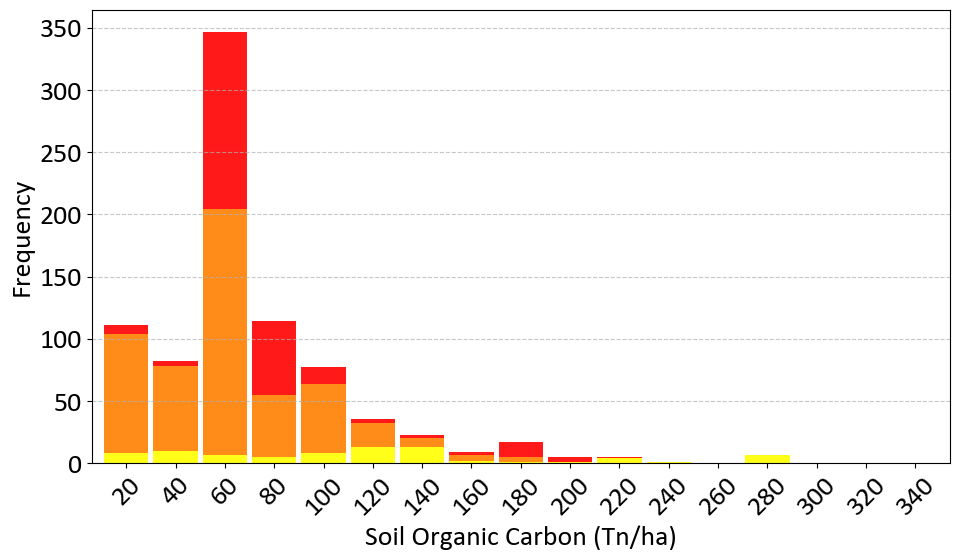

In [ ]:
def plot_soil_organic_carbon(df):
    """Generates a histogram of soil organic carbon with 10-ton/ha intervals,
    showing the proportion of CO₂ flux without the descriptive statistics box."""
    
    # Filter relevant column
    soil_carbon = df["Soil_Organic_Carbon_ton_ha"]

    # Define histogram bins for soil organic carbon
    bins_soil = np.arange(0, df["Soil_Organic_Carbon_ton_ha"].max() + 10, 20)

    # Group data by CO₂ flux and soil organic carbon
    grouped_data = df.groupby(pd.cut(df["Soil_Organic_Carbon_ton_ha"], bins=bins_soil))["Flux_log_range"].value_counts().unstack().fillna(0)

    # Extract only final interval values for the X-axis
    tick_labels = [str(int(b)) for b in bins_soil[1:]]
    plt.rcParams["font.family"] = "Calibri"  
    plt.rcParams["font.size"] = 20  
    
    # Create figure
    plt.figure(figsize=(12, 6))
    orig_map=plt.cm.get_cmap('autumn') 
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))

    # Graph configuration
    plt.xlabel("Soil Organic Carbon (Tn/ha)")
    plt.ylabel("Frequency")
    #plt.title("Soil Organic Carbon with Flux Proportion")  
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Adjust X-axis labels to show only final interval values
    ax.set_xticklabels(tick_labels, rotation=45)
    
    # Remove legend
    ax.get_legend().remove()
    #plt.legend(title="CO₂ Flux (g·m⁻²·d⁻¹)", bbox_to_anchor=(1.05, 1), loc="upper left")  
    
    # Save the image with adjusted dpi
    plt.savefig("figures/figure_7c.png", dpi=300, bbox_inches="tight")
    
    # Show the graph
    plt.tight_layout()
    plt.show()

# Run function with dataset
plot_soil_organic_carbon(df)

**Observations:**
- Higher soil organic carbon often corresponds to greater microbial activity, potentially increasing CO₂ flux from respiration.
- This plot helps determine if higher SOC bins align with high flux categories.

### 4.8.4 Annual Mean Temperature

<Figure size 1200x600 with 0 Axes>

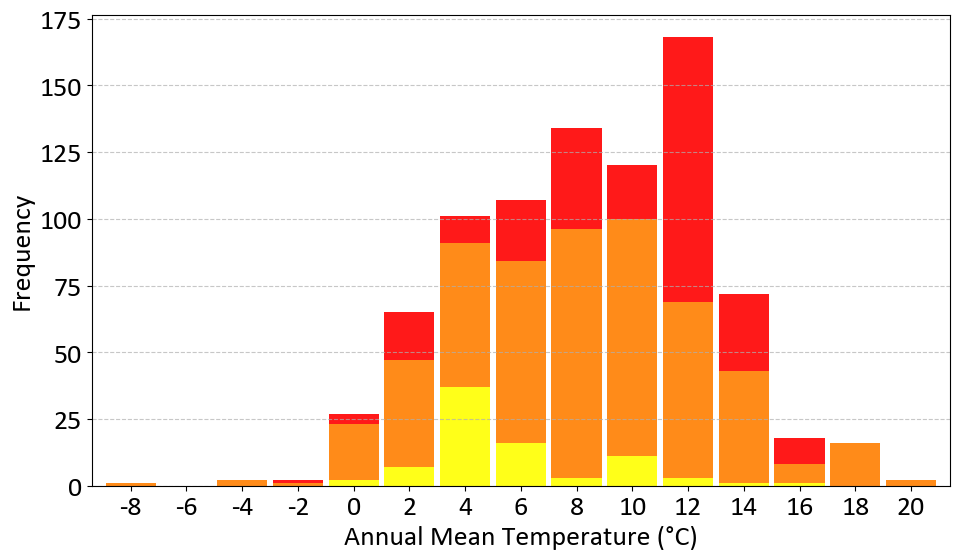

In [ ]:
def plot_annual_mean_temperature(df):
    """Generates a histogram of annual mean temperature with 2°C intervals,
    showing the proportion of CO₂ flux without the descriptive statistics box."""
    
    # Filter relevant column
    annual_temp = df["Annual_Mean_Temperature_C"]

    # Define histogram bins for annual mean temperature
    bins_temp = np.arange(-10, 22, 2)

    # Group data by CO₂ flux and annual mean temperature
    grouped_data = df.groupby(pd.cut(df["Annual_Mean_Temperature_C"], bins=bins_temp))["Flux_log_range"].value_counts().unstack().fillna(0)

    # Extract only final interval values for the X-axis
    tick_labels = [str(int(b)) for b in bins_temp[1:]]
    plt.rcParams["font.family"] = "Calibri"  
    plt.rcParams["font.size"] = 20  
    
    # Create figure
    plt.figure(figsize=(12, 6))
    orig_map=plt.cm.get_cmap('autumn') 
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))

    # Graph configuration
    plt.xlabel("Annual Mean Temperature (°C)")
    plt.ylabel("Frequency")
    #plt.title("Distribution of Mean Temperature with Flux Proportion")  
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Adjust X-axis labels to show only final interval values
    ax.set_xticklabels(tick_labels, rotation=0)
    
    # Remove legend
    ax.get_legend().remove()
    #plt.legend(title="CO₂ Flux (g·m⁻²·d⁻¹)", bbox_to_anchor=(1.05, 1), loc="upper left")  
    
    plt.savefig("figures/figure_7d.png", dpi=300, bbox_inches="tight")
    
    # Show the graph
    plt.tight_layout()
    plt.show()

# Run function with dataset
plot_annual_mean_temperature(df)

**Observations:**
- Temperature is a key driver of atmospheric and climatic processes, shaping local weather conditions and influencing how CO₂ is distributed and exchanged near the surface.
- By segmenting temperature into 2°C bins, you can check if warmer or colder conditions coincide with certain flux levels.


### 4.8.5 CO₂ at 1000 hPa

<Figure size 1000x600 with 0 Axes>

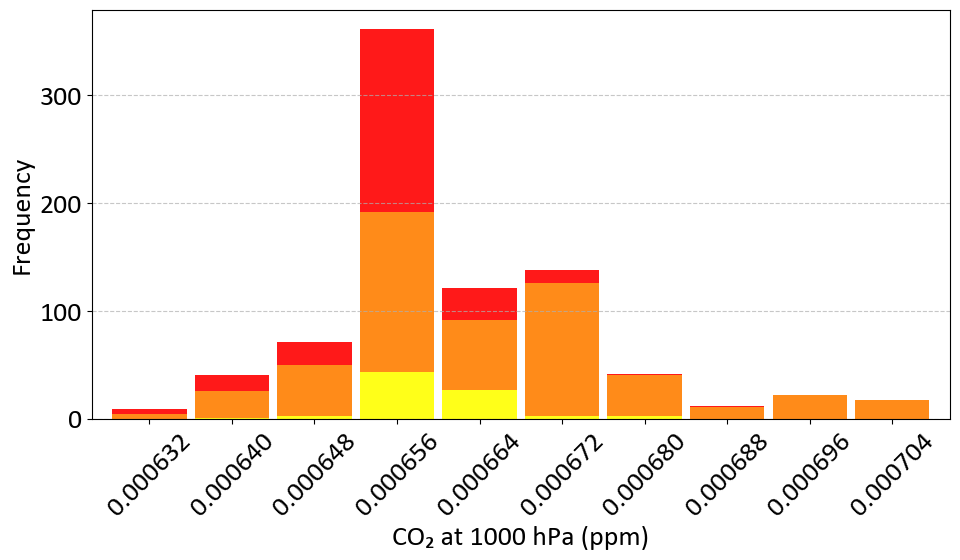

In [ ]:
def plot_co2_1000hpa_histogram(df):
    """Generates a stacked bar chart showing the distribution of CO₂ at 1000 hPa
    with the proportion of CO₂ flux in each category."""

    # Check if the column exists
    if "CO2_1000hPa" not in df.columns:
        print("Error: The column 'CO2_1000hPa' is not in the DataFrame.")
        return

    # Define bins based on the actual data range
    co2_min = df["CO2_1000hPa"].min()
    co2_max = df["CO2_1000hPa"].max()

    # If the difference between min and max is too small, artificially expand the range
    if np.isclose(co2_min, co2_max, atol=1e-6):  
        co2_min -= 1e-6
        co2_max += 1e-6

    bins = np.linspace(co2_min, co2_max, num=11)  

    # Create labels with higher decimal precision
    labels = [f"{bins[i+1]:.6f}" for i in range(len(bins)-1)]  

    # Categorize CO2 values into defined bins
    df["CO2_1000hPa_Category"] = pd.cut(df["CO2_1000hPa"], bins=bins, labels=labels, include_lowest=True, ordered=False)

    # Check if there are data points within the bins
    if df["CO2_1000hPa_Category"].isna().all():
        print("Error: No values in 'CO2_1000hPa' fall within the defined bins.")
        return

    # Group data by CO₂ flux and CO2_1000hPa category
    grouped_data = df.groupby("CO2_1000hPa_Category")["Flux_log_range"].value_counts().unstack().fillna(0)

    # Ensure CO2 values remain in numerical order
    grouped_data = grouped_data.reindex(labels)

    # Create figure with vertical bar chart
    plt.figure(figsize=(10, 6))
    orig_map=plt.cm.get_cmap('autumn') 
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))

    # Graph configuration
    plt.xlabel("CO₂ at 1000 hPa (ppm)")  
    plt.ylabel("Frequency")  
    #plt.title("Distribution of CO₂ at 1000 hPa with Flux Proportion")  
    plt.grid(axis='y', linestyle='--', alpha=0.7)  
    plt.xticks(rotation=45)
    
    # Remove legend
    ax.get_legend().remove()
    #plt.legend(title="CO₂ Flux (g·m⁻²·d⁻¹)", bbox_to_anchor=(1.05, 1), loc="upper left")  
    plt.savefig("figures/figure_7e.png", dpi=300, bbox_inches="tight")
    
    # Show the graph
    plt.tight_layout()
    plt.show()

# Run function with dataset
plot_co2_1000hpa_histogram(df)

**Observations:**
- Ambient CO₂ concentrations at 1000 hPa may vary by region or climate.
- Stacking by flux category could reveal whether areas with higher local CO₂ levels also exhibit elevated surface fluxes (though many factors likely contribute).


### 4.8.6 Total Column CO₂ 

<Figure size 1000x600 with 0 Axes>

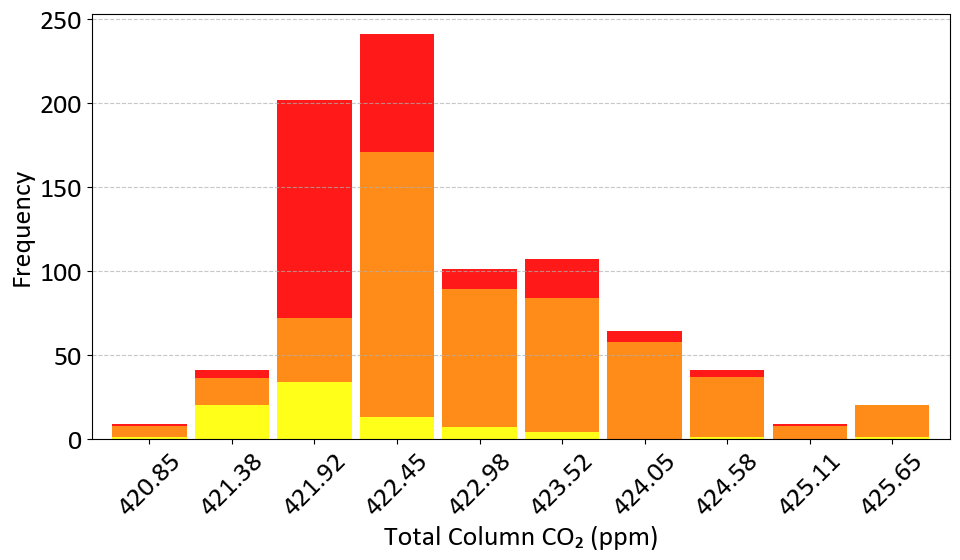

In [ ]:
def plot_total_column_co2_histogram(df):
    """Generates a stacked bar chart showing the distribution of Total Column CO₂
    with the proportion of CO₂ flux in each category."""

    # Check if the column exists
    if "Total_Column_CO2" not in df.columns:
        print("Error: The column 'Total_Column_CO2' is not in the DataFrame.")
        return

    # Define bins based on the actual data range
    co2_min = df["Total_Column_CO2"].min()
    co2_max = df["Total_Column_CO2"].max()

    # If the difference between min and max is too small, artificially expand the range
    if np.isclose(co2_min, co2_max, atol=0.01):  
        co2_min -= 0.01
        co2_max += 0.01

    bins = np.linspace(co2_min, co2_max, num=11)  

    # Create labels with proper format
    labels = [f"{bins[i+1]:.2f}" for i in range(len(bins)-1)]  

    # Categorize CO₂ values into defined bins
    df["Total_Column_CO2_Category"] = pd.cut(df["Total_Column_CO2"], bins=bins, labels=labels, include_lowest=True, ordered=False)

    # Check if there are data points within the bins
    if df["Total_Column_CO2_Category"].isna().all():
        print("Error: No values in 'Total_Column_CO2' fall within the defined bins.")
        return

    # Group data by CO₂ flux and Total_Column_CO2 category
    grouped_data = df.groupby("Total_Column_CO2_Category")["Flux_log_range"].value_counts().unstack().fillna(0)

    # Ensure CO₂ values remain in numerical order
    grouped_data = grouped_data.reindex(labels)
    plt.rcParams["font.family"] = "Calibri"  
    plt.rcParams["font.size"] = 20 
    
    # Create figure with vertical bar chart
    plt.figure(figsize=(10, 6))
    orig_map=plt.cm.get_cmap('autumn') 
    reversed_map = orig_map.reversed()
    ax = grouped_data.plot(kind="bar", stacked=True, colormap=reversed_map, width=0.9, alpha=0.9, figsize=(10, 6))
    plt.xticks(rotation=45)
    
    # Graph configuration
    plt.xlabel("Total Column CO₂ (ppm)")  
    plt.ylabel("Frequency")  
    #plt.title("Distribution of Total Column CO₂ with Flux Proportion")  
    plt.grid(axis='y', linestyle='--', alpha=0.7)  
    # Remove legend
    ax.get_legend().remove()
    #plt.legend(title="CO₂ Flux (g·m⁻²·d⁻¹)", bbox_to_anchor=(1.05, 1), loc="upper left")  
    
    plt.savefig("figures/figure_7f.png", dpi=300, bbox_inches="tight")
    
    # Show the graph
    plt.tight_layout()
    plt.show()

# Run function with dataset
plot_total_column_co2_histogram(df)

**Observations:**
- Total column CO₂ refers to the integrated amount of CO₂ in the air column above a given location.
- Areas with anomalously high total column CO₂ might coincide with regions of strong surface degassing, though atmospheric transport and mixing can also play significant roles.

## Key Takeaways for Environmental Variables

1. **Soil pH:** Influences microbial and chemical processes.  
2. **Tree Cover:** Affects net primary production and microclimate factors.  
3. **Soil Organic Carbon (SOC):** A proxy for biological activity that can drive CO₂ production in soils.  
4. **Annual Mean Temperature:** Warmer regions may have higher respiration rates, but many confounding factors exist.  
5. **CO₂ at 1000 hPa & Total Column CO₂:** Provide atmospheric CO₂ context; localized flux might or might not match the broader atmospheric signal depending on regional and global transport patterns.

# 5. Data Cleaning and Feature Transformation

In this section, we remove unwanted columns, apply inverse-distance transformations to selected distance variables, rename columns for clearer readability, and finally perform correlation analyses (Pearson and Spearman) to guide feature selection or reduction.

## 5.1 - Removing Unused Columns

In [34]:
print("Columns in DataFrame:\n", df.columns.tolist())

columns_to_drop = [
    'Longitude (x)', 'Latitude (y)', 'Geothermal_Gradient_C_deg_km',
    'mineralization_TipoMinera', 'mineral_commodity_group', 'CO_1000hPa',
    'Geopotential_1000hPa', 'Flux_CO2_GPP', 'Geopotential_Sup_Avg',
    'Flux_log_range', 'Fault_Distance_Categories', "Flux (gm-2d-1)",
    'Mineralization_Distance_Categories', 'Volcano_Distance_Categories',
    'PGA_Category', 'Gradient_Binned', 'CO2_1000hPa_Category',
    'CO_1000hPa_Category', 'Geopotential_1000hPa_Category',
    'Geopotential_Sup_Avg_Category', 'Total_Column_CO2_Category',
    'Soil_pH_Category', 'Tree_Cover_Category', 'Porosity_Category',
    'Permeability_Category', 'Elevation_Categories',
    'Mineral_Commodity_Distance_Categories', 'Elevation_m'
]

co2_flux = df.drop(columns=columns_to_drop, errors='ignore')
print("\nDataFrame shape after dropping columns:", co2_flux.shape)

Columns in DataFrame:
 ['Longitude (x)', 'Latitude (y)', 'Flux (gm-2d-1)', 'Geothermal_Gradient_C_deg_km', 'Bouguer_Anomaly_mGal', 'Heat_Flow_mW_m2', 'Annual_Mean_Temperature_C', 'Soil_Organic_Carbon_ton_ha', 'Soil_pH_H2O', 'Elevation_m', 'faults_distance_km', 'geological_province_prov_type', 'mineralization_distance_km', 'mineralization_TipoMinera', 'volcano_distance_km', 'mineral_commodity_distance_km', 'Slip_type_general_Id', 'mineral_commodity_group', 'Available_Water_Storage_mm/m', 'Tree_Cover_Percentage', 'Porosity', 'Permeability_permafrost', 'PGA_Mean', 'Lithology', 'CO2_1000hPa', 'CO_1000hPa', 'Geopotential_1000hPa', 'Flux_CO2_GPP', 'Total_Column_CO2', 'Geopotential_Sup_Avg', 'Flux_log', 'Flux_log_range', 'Fault_Distance_Categories', 'PGA_Category', 'Mineral_Commodity_Distance_Categories', 'Mineralization_Distance_Categories', 'Volcano_Distance_Categories', 'Permeability_Category', 'Porosity_Category', 'Soil_pH_Category', 'Tree_Cover_Category', 'CO2_1000hPa_Category', 'Total_C

**Note:**
- We removed columns considered irrelevant or redundant for modeling, and those created for graphical representation of variables.
- `errors='ignore'` prevents an error from being generated if a column does not exist in the DataFrame.

## 5.2 - Inverse-Distance Transformation

We apply an inverse-distance transformation so that:
- Shorter distances receive **greater weight** (high values when using 1/d²).
- Very large distances have **minimal influence** on the model.

In [35]:
columns_to_transform = [
    'faults_distance_km',
    'volcano_distance_km',
    'mineralization_distance_km',
    'mineral_commodity_distance_km'
]

small_value = 0.001  # Represents 10 meters, avoids division by zero
for col in columns_to_transform:
    co2_flux[col] = co2_flux[col].replace(0, small_value)
    co2_flux[col] = 1 / (co2_flux[col]**2)  # Inverse transformation

**Rationale:**  
- Emphasize the effect of proximity to geological features (e.g., faults, volcanoes).  
- Strongly penalize extremely large distances (e.g., >300 km).

## 5.3 - Dropping Categorical Variables

We drop certain categorical variables after testing them across models and combinations. They did not improve performance, so we opt to keep only numeric features.

In [36]:
columns_to_drop_categoricals = [
    'Lithology',
    'geological_province_prov_type',
    'Slip_type_general_Id'
]

co2_flux.drop(columns=columns_to_drop_categoricals, errors='ignore', inplace=True)
print("DataFrame shape after dropping categorical columns:", co2_flux.shape)

DataFrame shape after dropping categorical columns: (835, 17)


## 5.4 - Renaming Columns

We rename selected columns for better presentation in subsequent analyses and plots.

In [37]:
column_mapping = {
    'Bouguer_Anomaly_mGal': 'Bouguer Anomaly (mGal)',
    'Heat_Flow_mW_m2': 'Heat Flow (mW/m²)',
    'Annual_Mean_Temperature_C': 'Annual Mean Temperature (°C)',
    'Soil_Organic_Carbon_ton_ha': 'Soil Organic Carbon (Tn/ha)',
    'Soil_pH_H2O': 'Soil pH',
    'Elevation_m': 'Elevation (m)',
    'faults_distance_km': 'Distance to Nearest Fault (Km)',
    'mineralization_distance_km': 'Distance to Nearest Mineralization (Km)',
    'volcano_distance_km': 'Distance to Nearest Volcano (Km)',
    'mineral_commodity_distance_km': 'Distance to Nearest Mineral Product (Km)',
    'Available_Water_Storage_mm/m': 'Available Water Storage (mm/m)',
    'Tree_Cover_Percentage': 'Tree Cover (%)',
    'Porosity': 'Porosity (%)',
    'Permeability_permafrost': 'Permeability (logk m²)',
    'PGA_Mean': 'PGA (g)',
    'CO2_1000hPa': 'Carbon Dioxide at 1000 hPa (kg kg⁻¹)',
    'Total_Column_CO2': 'Mean Column Molar Fraction of CO2 (ppm)',
    'Flux_log': 'Log of Flux'
}

co2_flux.rename(columns=column_mapping, inplace=True)
print("Columns after renaming:\n", co2_flux.columns.tolist())

Columns after renaming:
 ['Bouguer Anomaly (mGal)', 'Heat Flow (mW/m²)', 'Annual Mean Temperature (°C)', 'Soil Organic Carbon (Tn/ha)', 'Soil pH', 'Distance to Nearest Fault (Km)', 'Distance to Nearest Mineralization (Km)', 'Distance to Nearest Volcano (Km)', 'Distance to Nearest Mineral Product (Km)', 'Available Water Storage (mm/m)', 'Tree Cover (%)', 'Porosity (%)', 'Permeability (logk m²)', 'PGA (g)', 'Carbon Dioxide at 1000 hPa (kg kg⁻¹)', 'Mean Column Molar Fraction of CO2 (ppm)', 'Log of Flux']


# 6. Feature Selection and Correlation Analysis

We now examine how each variable relates to the target variable (**Log of Flux**). We use two correlation measures:

- **Pearson**: Captures linear relationships.  
- **Spearman**: Captures monotonic relationships (not necessarily linear).

We also present a combined matrix with:
- **Pearson (upper triangle)**
- **Spearman (lower triangle)**

### 6.1 - Combined Correlation Matrix (Spearman & Pearson)

This combined matrix visualizes Pearson correlation on the upper triangle and Spearman correlation on the lower triangle, reducing the number of figures needed.

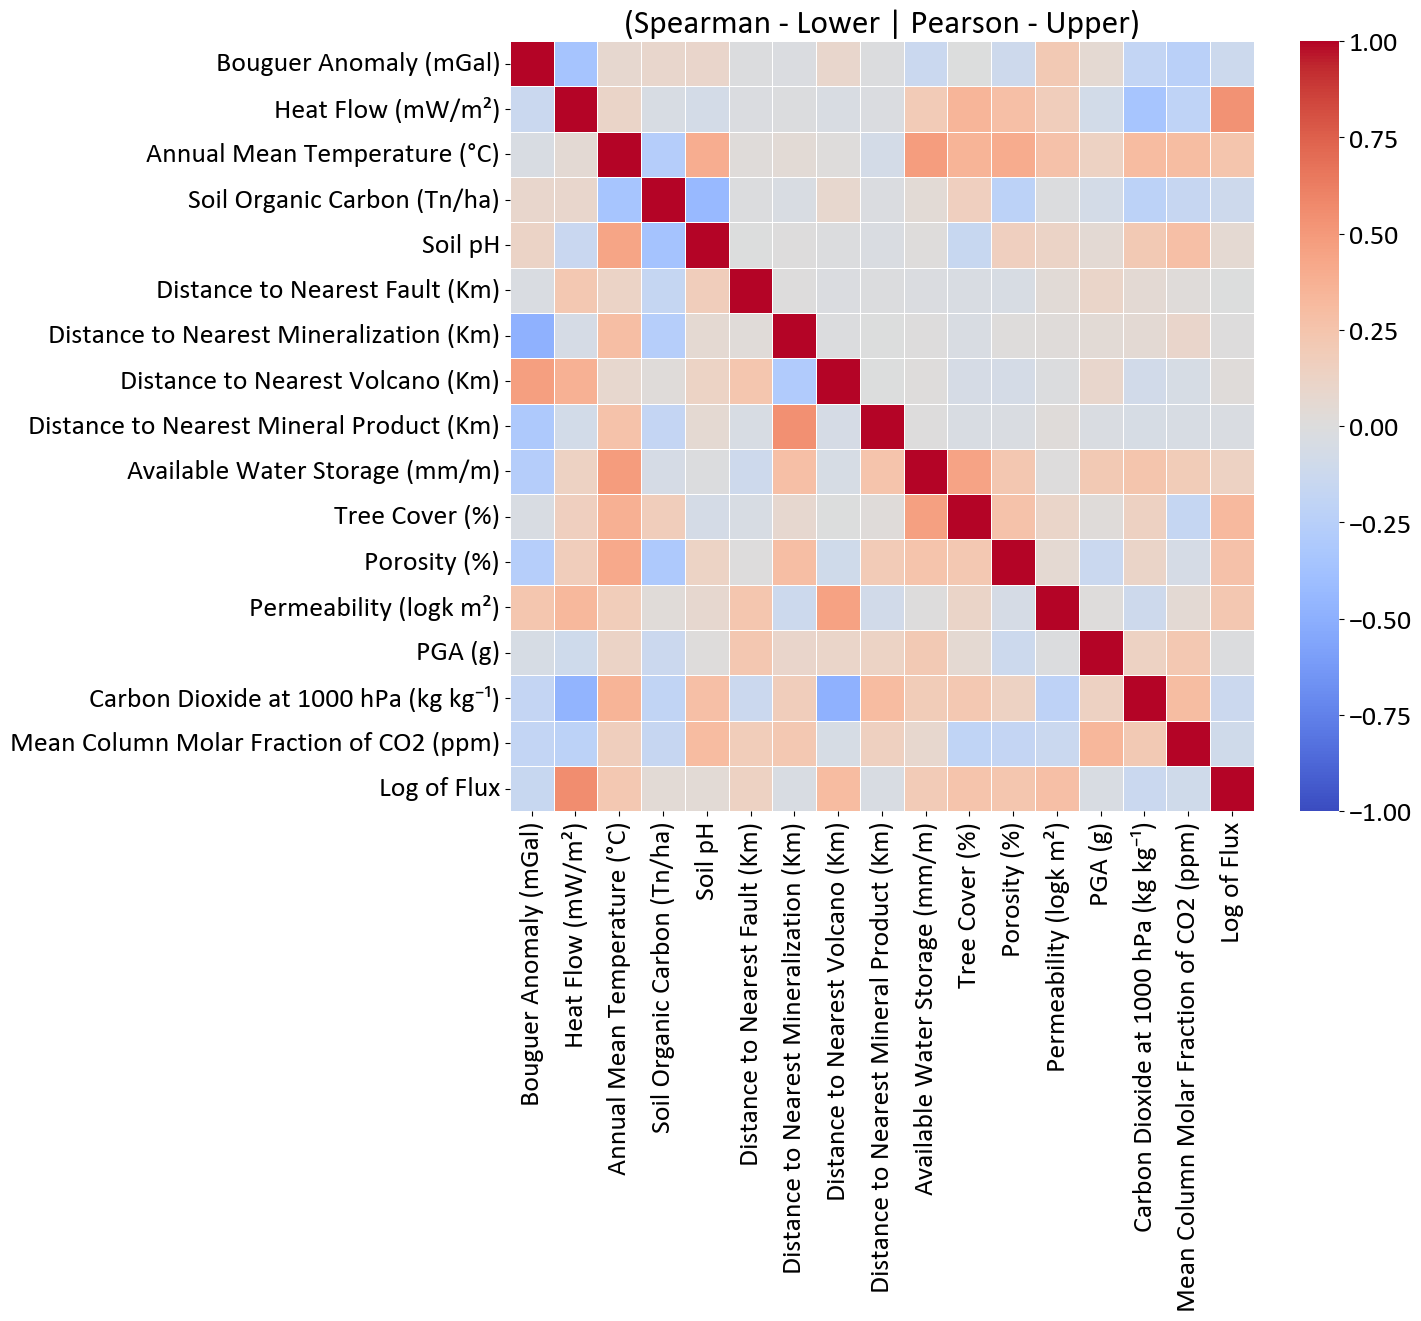

In [38]:
# Compute correlation matrices
pearson_corr = co2_flux.corr(method='pearson')
spearman_corr = co2_flux.corr(method='spearman')

# Create a copy of Pearson for the combined matrix
combined_corr = pearson_corr.copy()

# Create masks for the upper and lower triangles (excluding diagonal)
mask_upper = np.triu(np.ones(pearson_corr.shape, dtype=bool), k=1)  # Upper triangle
mask_lower = np.tril(np.ones(spearman_corr.shape, dtype=bool), k=-1)  # Lower triangle

# Fill the combined matrix with corresponding correlations
for i in range(len(pearson_corr.columns)):
    for j in range(len(pearson_corr.columns)):
        if mask_upper[i, j]:  # If in the upper part -> Pearson
            combined_corr.iloc[i, j] = pearson_corr.iloc[i, j]
        elif mask_lower[i, j]:  # If in the lower part -> Spearman
            combined_corr.iloc[i, j] = spearman_corr.iloc[i, j]

# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# Draw the combined heatmap
sns.heatmap(combined_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, 
            xticklabels=pearson_corr.columns, yticklabels=pearson_corr.columns, linewidths=0.5, ax=ax)

# Add title
ax.set_title("(Spearman - Lower | Pearson - Upper)")
plt.savefig("figures/figure_8.png", dpi=300, bbox_inches="tight")

# Show figure
plt.show()


**Conclusion:**  
- A single heatmap reflects both linear (upper) and monotonic (lower) relationships.  
- Facilitates deciding which variables are more relevant or influential based on the type of correlation you want to capture.

### 6.2 - Final Feature List and Data Export

In [39]:
features_preselected = [col for col in co2_flux.columns if col != 'Log of Flux']
print("Preselected features:\n", features_preselected)

# Optionally, export the final DataFrame
#co2_flux.to_excel("Flujo_Recopilado.xlsx", index=False, sheet_name="Datos_CO2_Flux")

Preselected features:
 ['Bouguer Anomaly (mGal)', 'Heat Flow (mW/m²)', 'Annual Mean Temperature (°C)', 'Soil Organic Carbon (Tn/ha)', 'Soil pH', 'Distance to Nearest Fault (Km)', 'Distance to Nearest Mineralization (Km)', 'Distance to Nearest Volcano (Km)', 'Distance to Nearest Mineral Product (Km)', 'Available Water Storage (mm/m)', 'Tree Cover (%)', 'Porosity (%)', 'Permeability (logk m²)', 'PGA (g)', 'Carbon Dioxide at 1000 hPa (kg kg⁻¹)', 'Mean Column Molar Fraction of CO2 (ppm)']


**Note:**  
- We keep `Log of Flux` as the target variable.  
- Exporting to Excel enables further external analysis or later modeling steps.

# 7. Predictive Modeling

This section covers:
1. Splitting the dataset into training/validation/test sets.
2. Scaling the features.
3. Training and tuning Models.
4. Evaluating performance on validation and test sets.
5. Generating learning curves and interpretability plots (Permutation Importance, Partial Dependence, and SHAP).

## 7.1 Splitting Features (X) and Target (y)

We drop the target column 'Log of Flux' to form X, and use 'Log of Flux' as y. Then, we apply a standard scaler to the features.


In [40]:
# Separate features (X) and target (y)
X = co2_flux.drop(columns=['Log of Flux'])
y = co2_flux['Log of Flux']

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a DataFrame from the scaled features, optionally naming columns
X_df = pd.DataFrame(X_scaled, columns=features_preselected)

## 7.2 Train-Validation-Test Split

We split the dataset such that:
- 70% is used for training (with cross-validation to tune hyperparameters).
- The remaining 30% is split evenly for validation and testing.

This ensures we have separate data for hyperparameter tuning (training + CV) and final model performance evaluation (test + validation).

In [41]:
# Example: 70% train, 30% test+validation
X_train, X_test_val, y_train, y_test_val = train_test_split(
    X_df, y, test_size=0.30, random_state=42
)

# Then split the remaining 30% equally between validation and test
X_val, X_test, y_val, y_test = train_test_split(
    X_test_val, y_test_val, test_size=0.50, random_state=42
)

print(f"Training set:   {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set:       {X_test.shape}, {y_test.shape}")

Training set:   (584, 16), (584,)
Validation set: (125, 16), (125,)
Test set:       (126, 16), (126,)


**Note**:  
- When performing hyperparameter tuning (e.g., with GridSearchCV), we typically use a cross-validation split **within** the training data to avoid data leakage and to maximize training examples.
- After finding the best hyperparameters, we can finalize the model and evaluate on validation and test sets.


## 7.3 Training and Evaluating Models

Below, we train and evaluate different models. The workflow is:

1. Define the model and parameter grid for hyperparameter tuning.
2. Use `GridSearchCV` with k-fold cross-validation on the training data.
3. Evaluate the best estimator on **test** and **validation** sets.
4. Plot learning curves to diagnose bias/variance issues.
5. Use interpretability tools (Permutation Importance, Partial Dependence, and SHAP) to understand the model’s behavior.

In [42]:
# -----------------------
# Function to plot learning curve
# -----------------------

# Modified function to automatically save images
def plot_learning_curve(estimator, X, y, title="Learning Curve"):
    """
    Plots the learning curve of a model and saves it as an image.
    
    Parameters:
        estimator: Machine Learning model.
        X: Predictor variables.
        y: Target variable.
        title: Plot title (optional).
    """
    # Compute learning curves
    train_sizes, train_scores, cv_scores = learning_curve(estimator, X, y, cv=5, scoring='r2', n_jobs=-1,
                                                          train_sizes=np.linspace(0.1, 1.0, 10))
    train_scores_mean = np.mean(train_scores, axis=1)
    cv_scores_mean = np.mean(cv_scores, axis=1)
    
    # Create figure
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, cv_scores_mean, 'o-', color="g", label="CV score")
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("R²")
    plt.legend(loc="best")
    plt.grid(True)
    
    # Get model name and create filename
    model_name = type(estimator).__name__  # Extracts the model class name
    file_name = f"{model_name}_Learning_Curve.png"
    
    # Save figure
    #plt.savefig(file_name, dpi=600, bbox_inches="tight")
    
    # Show figure
    plt.show()

    print(f"Learning curve saved as: {file_name}")

In [43]:
# We'll store our results in a list for a final comparison
results = []

### 7.3.1 **Support Vector Regression (SVR)**

We use GridSearchCV to explore different kernels, C values, gamma settings, and epsilon values. Then we pick the best model and evaluate it.


In [44]:
# -----------------------
# 2. Model: SVR (Support Vector Regression)
# -----------------------
print("\n=== SVR ===")
svr = SVR()
param_grid_svr = {
    'kernel': ['rbf', 'poly', 'sigmoid'],  
    'C': [1e-3, 1e-1, 1, 10, 100],         
    'gamma': ['scale', 'auto'],
    'epsilon': [0.001, 0.01, 0.1, 0.5, 1], 
    
}
grid_svr = GridSearchCV(svr, param_grid_svr, scoring='r2', cv=5, n_jobs=-1, verbose=1)
grid_svr.fit(X_train, y_train)
print("Mejores parámetros SVR:", grid_svr.best_params_)
best_svr = grid_svr.best_estimator_


=== SVR ===
Fitting 5 folds for each of 150 candidates, totalling 750 fits
Mejores parámetros SVR: {'C': 10, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}


In [45]:
# Evaluate on TEST set
y_pred_test = best_svr.predict(X_test)
svr_test_r2 = r2_score(y_test, y_pred_test)
svr_test_mse = mean_squared_error(y_test, y_pred_test)
svr_test_mae = mean_absolute_error(y_test, y_pred_test)

In [46]:
# Evaluate on VALIDATION set
y_pred_val = best_svr.predict(X_val)
svr_val_r2 = r2_score(y_val, y_pred_val)
svr_val_mse = mean_squared_error(y_val, y_pred_val)
svr_val_mae = mean_absolute_error(y_val, y_pred_val)

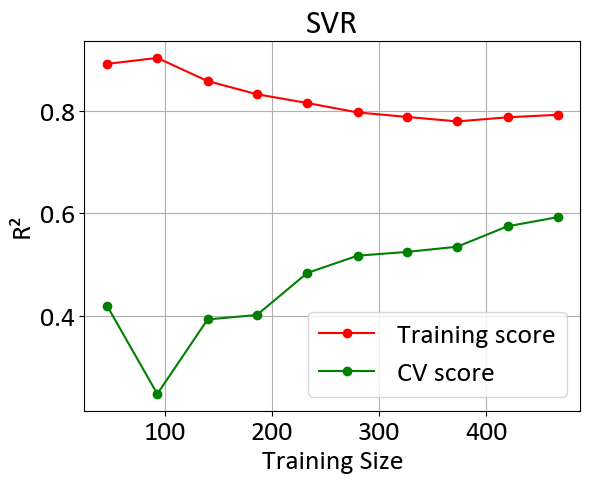

Learning curve saved as: SVR_Learning_Curve.png


In [47]:
# Plot learning curve for SVR
plot_learning_curve(best_svr, X_train, y_train, title="SVR")

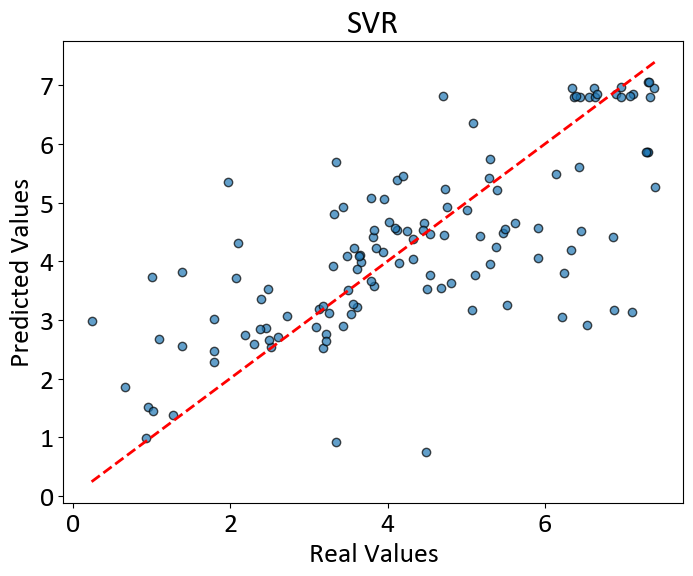

In [48]:
# -----------------------------------------------
# Plot 1: Predicted vs Actual Values (TEST)
# -----------------------------------------------
plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred_val, alpha=0.7, edgecolor='k')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--', lw=2)
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("SVR")
plt.savefig("figures/figure_10a.png", dpi=300, bbox_inches="tight") 
plt.show()

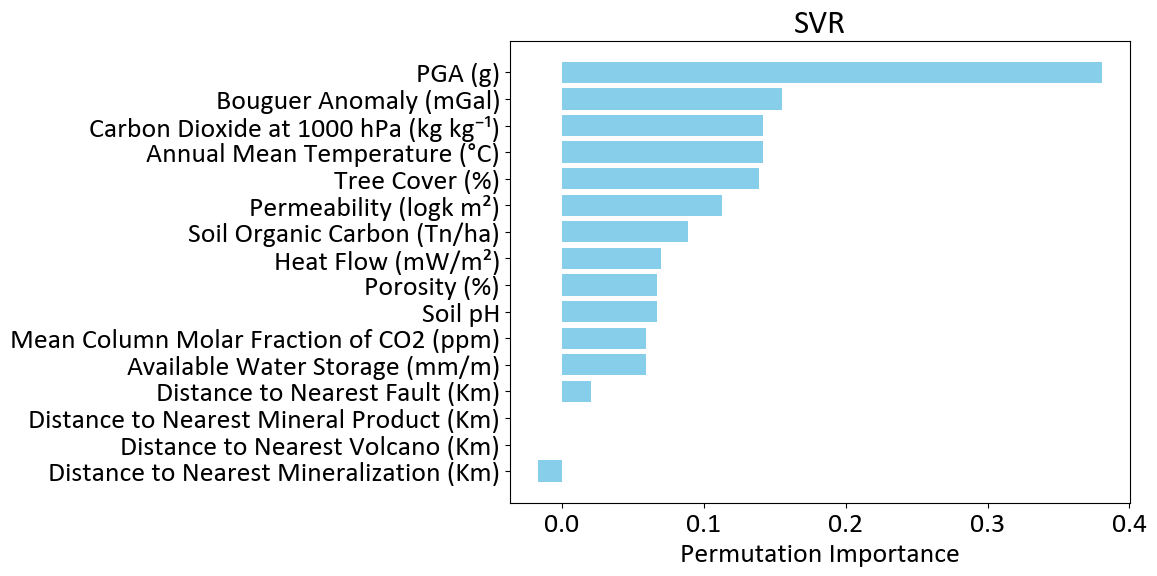

In [49]:
# ==============================
# 1. Permutation Importance
# ==============================
perm_importance_svr = permutation_importance(best_svr, X_val, y_val, n_repeats=10, random_state=42)

# Sort features by importance (highest to lowest)
sorted_idx = np.argsort(perm_importance_svr.importances_mean)[::-1]
features_sorted = np.array(features_preselected)[sorted_idx]

# Feature importance plot
plt.figure(figsize=(8,6))
plt.barh(features_sorted, perm_importance_svr.importances_mean[sorted_idx], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Permutation Importance")
plt.title("SVR")
plt.savefig("figures/figure_11a.png", dpi=300, bbox_inches="tight")  
plt.show()

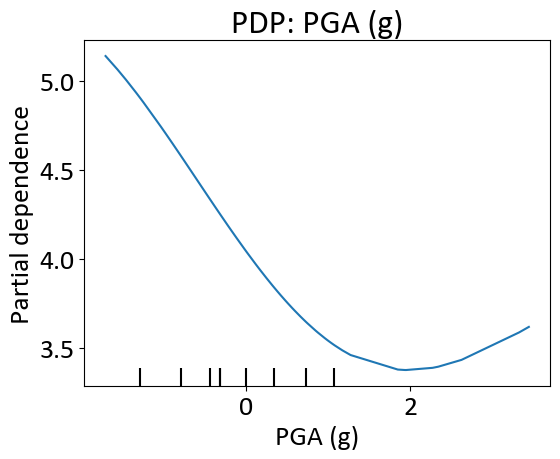

In [50]:
# ==========================================
# 2. Partial Dependence Plot for the most important variable
# ==========================================
fig, ax = plt.subplots(figsize=(6,5))
# Plot the PDP for the most important feature
PartialDependenceDisplay.from_estimator(best_svr, X_val, [top_features[0]], ax=ax)
ax.set_title(f"PDP: {top_features[0]}")
plt.tight_layout()
#plt.savefig("SVR_Partial_Dependence_First_Feature.png", dpi=300, bbox_inches="tight")
plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

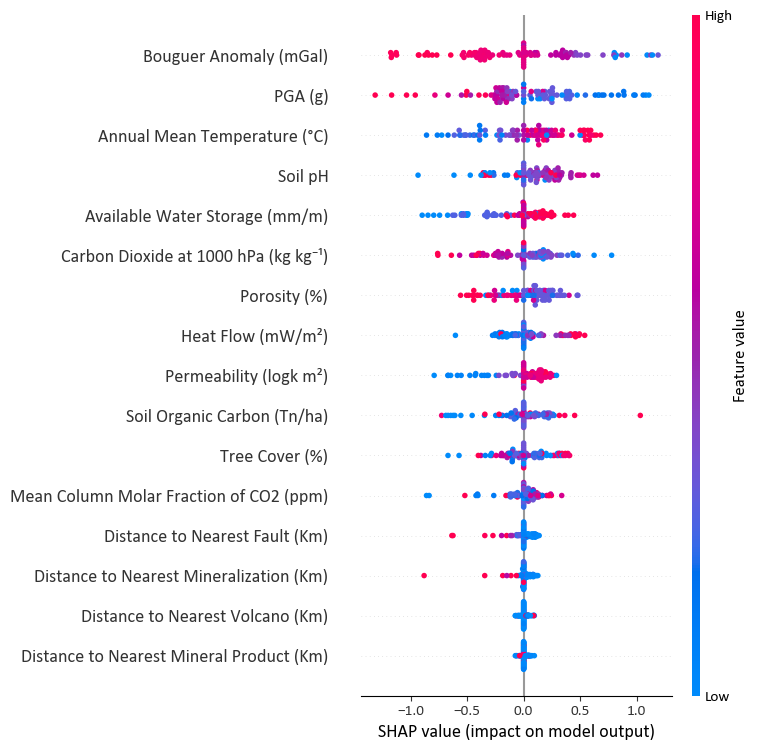

In [51]:
# ==============================
# 3. SHAP Summary with KernelExplainer
# ==============================

if isinstance(X_train, pd.DataFrame):
    X_train_sample = X_train.sample(50, random_state=42)
else:
    X_train_sample = X_train[:50]

if isinstance(X_test, pd.DataFrame):
    X_test_sample = X_val.sample(100, random_state=42)
else:
    X_test_sample = X_val[:100]

# Define the explainer using the SVR model's predict function
explainer = shap.KernelExplainer(best_svr.predict, X_train_sample)

# Compute SHAP values for the test sample (adjust nsamples based on available resources)
shap_values = explainer.shap_values(X_test_sample, nsamples=100)

# Create SHAP figure and save it
plt.figure()  # Create a new figure before plotting SHAP summary
shap.summary_plot(shap_values, X_test_sample, feature_names=features_preselected, show=False) 

# Save the image before displaying it
plt.savefig("figures/figure_12a.png", dpi=300, bbox_inches="tight")

# Show the image
plt.show()


In [52]:
results.append({
    'Modelo': 'SVR_Regressor',
    'Test_R2': svr_test_r2,
    'Test_MSE': svr_test_mse,
    'Test_MAE': svr_test_mae,
    'Val_R2': svr_val_r2,
    'Val_MSE': svr_val_mse,
    'Val_MAE': svr_val_mae
})

## KNN REGRESSOR

In [53]:
# -----------------------
# Model: KNN Regressor
# -----------------------
print("\n=== KNN Regressor ===")
knn = KNeighborsRegressor()

# Define a hyperparameter grid for KNN
param_grid_knn = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 15, 21],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    'p': [1, 2]  # Only used if 'metric' is 'minkowski'
}

# We perform hyperparameter search with cross-validation
grid_knn = GridSearchCV(knn, param_grid_knn, scoring='r2', cv=5, n_jobs=-1, verbose=1)
grid_knn.fit(X_train, y_train)
print("Mejores parámetros KNN:", grid_knn.best_params_)
best_knn = grid_knn.best_estimator_

# Evaluation in TEST
y_pred_test = best_knn.predict(X_test)
knn_test_r2 = r2_score(y_test, y_pred_test)
knn_test_mse = mean_squared_error(y_test, y_pred_test)
knn_test_mae = mean_absolute_error(y_test, y_pred_test)

# Evaluation in VALIDATION
y_pred_val = best_knn.predict(X_val)
knn_val_r2 = r2_score(y_val, y_pred_val)
knn_val_mse = mean_squared_error(y_val, y_pred_val)
knn_val_mae = mean_absolute_error(y_val, y_pred_val)


=== KNN Regressor ===
Fitting 5 folds for each of 2560 candidates, totalling 12800 fits
Mejores parámetros KNN: {'algorithm': 'kd_tree', 'leaf_size': 30, 'metric': 'manhattan', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}


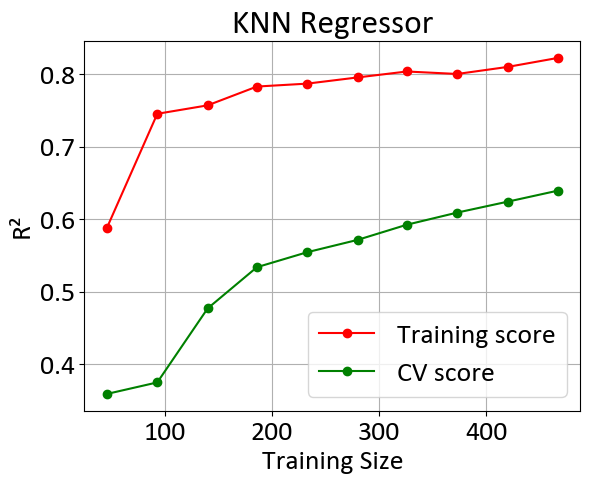

Learning curve saved as: KNeighborsRegressor_Learning_Curve.png


In [54]:
# Learning curve
plot_learning_curve(best_knn, X_train, y_train, title="KNN Regressor")


results.append({
    'Modelo': 'KNN_Regressor',
    'Test_R2': knn_test_r2,
    'Test_MSE': knn_test_mse,
    'Test_MAE': knn_test_mae,
    'Val_R2': knn_val_r2,
    'Val_MSE': knn_val_mse,
    'Val_MAE': knn_val_mae
})

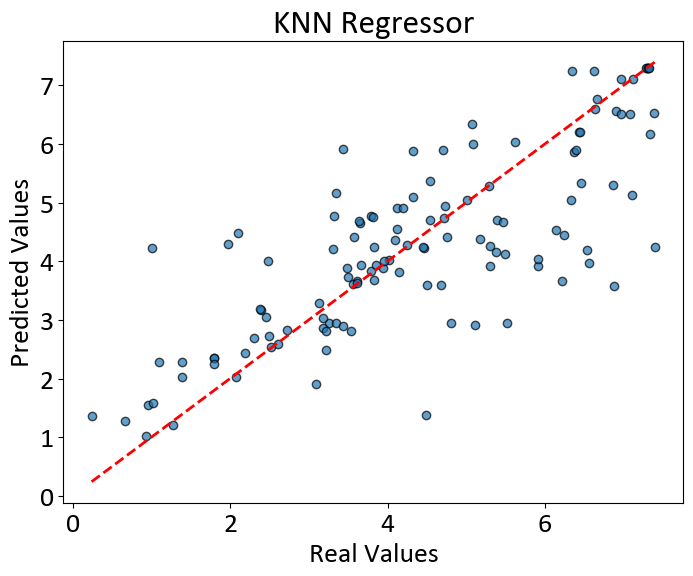

In [55]:
# -----------------------------------------------
# Plot 1: Predicted vs Actual Values (TEST) for KNN
# -----------------------------------------------
plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred_val, alpha=0.7, edgecolor='k')
# Ideal reference line (y = x)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--', lw=2)
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("KNN Regressor")
plt.savefig("figures/figure_10b.png", dpi=300, bbox_inches="tight") 
plt.show()

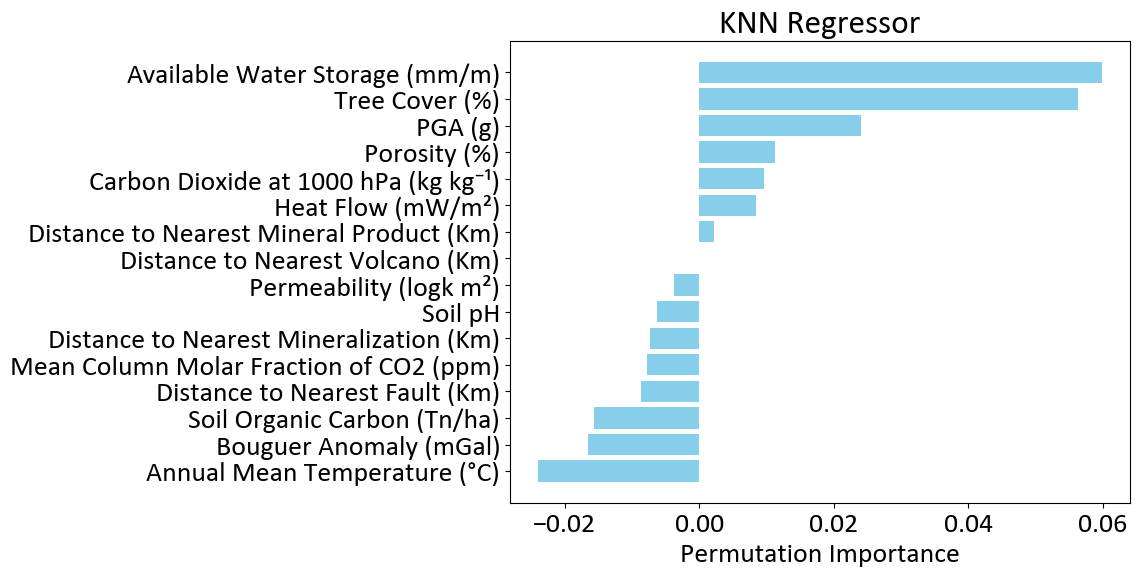

In [56]:
# 1. Compute feature importance using permutation
perm_importance_knn = permutation_importance(best_knn, X_val, y_val, n_repeats=10, random_state=42)

# Sort features by importance (highest to lowest)
sorted_idx = np.argsort(perm_importance_knn.importances_mean)[::-1]
features_sorted = np.array(features_preselected)[sorted_idx]

# --- Feature Importance Plot ---
plt.figure(figsize=(8,6))
plt.barh(features_sorted, perm_importance_knn.importances_mean[sorted_idx], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Permutation Importance")
plt.title("KNN Regressor")
plt.savefig("figures/figure_11b.png", dpi=300, bbox_inches="tight")  
plt.show()


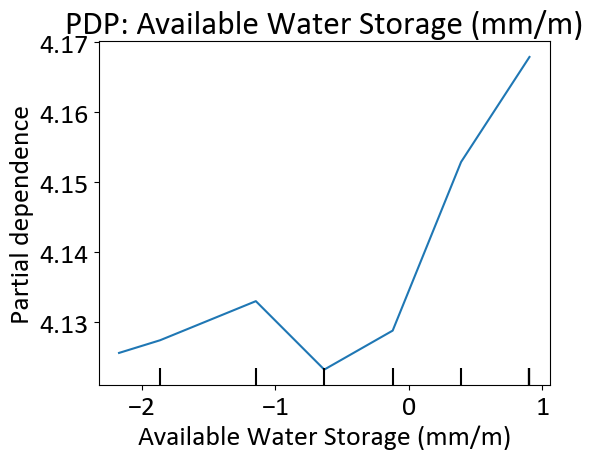

In [57]:
# 2. Partial Dependence Plot (PDP) for the most important variable
fig, ax = plt.subplots(figsize=(6, 5))
PartialDependenceDisplay.from_estimator(best_knn, X_train, [top_features[0]], ax=ax)
ax.set_title(f"PDP: {top_features[0]}")
plt.tight_layout()
#plt.savefig("KNN_Partial_Dependence.png", dpi=300, bbox_inches="tight") 
plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

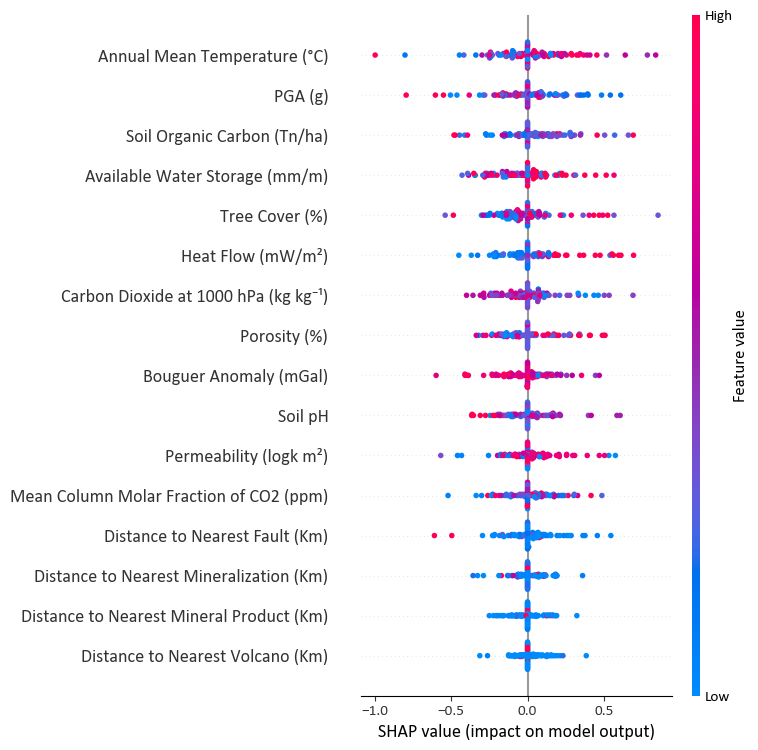

In [58]:
# 3. SHAP Summary using KernelExplainer

if isinstance(X_train, pd.DataFrame):
    X_train_sample = X_train.sample(50, random_state=42)
else:
    X_train_sample = X_train[:50]

if isinstance(X_test, pd.DataFrame):
    X_test_sample = X_val.sample(100, random_state=42)
else:
    X_test_sample = X_val[:100]

# Define the explainer using the model's predict function
explainer = shap.KernelExplainer(best_knn.predict, X_train_sample)

# Compute SHAP values for the test sample
# nsamples controls the number of evaluations to approximate SHAP values
shap_values = explainer.shap_values(X_test_sample, nsamples=100)

# Create SHAP figure and save it
plt.figure()  # Create a new figure before plotting SHAP summary
shap.summary_plot(shap_values, X_test_sample, feature_names=features_preselected, show=False) 

# Save the image before displaying it
plt.savefig("figures/figure_12b.png", dpi=300, bbox_inches="tight")

# Show the image
plt.show()


## ARBOL DE DECISION

In [59]:
# -----------------------
#  Model: Decision Tree
# -----------------------
print("\n=== Árbol de Decisión ===")
dt = DecisionTreeRegressor(random_state=42)
param_grid_dt = {
    'max_depth': [None, 3, 5, 7, 10, 15, 20], 
    'min_samples_split': [2, 5, 10, 20, 50],   
    'min_samples_leaf': [1, 2, 5, 10]          
}
grid_dt = GridSearchCV(dt, param_grid_dt, scoring='r2', cv=5, n_jobs=-1, verbose=1)
grid_dt.fit(X_train, y_train)
print("Mejores parámetros Árbol de Decisión:", grid_dt.best_params_)
best_dt = grid_dt.best_estimator_


=== Árbol de Decisión ===
Fitting 5 folds for each of 140 candidates, totalling 700 fits
Mejores parámetros Árbol de Decisión: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 50}


In [60]:
# Evaluation in TEST
y_pred_test = best_dt.predict(X_test)
dt_test_r2 = r2_score(y_test, y_pred_test)
dt_test_mse = mean_squared_error(y_test, y_pred_test)
dt_test_mae = mean_absolute_error(y_test, y_pred_test)

In [61]:
# Evaluation in VALIDATION
y_pred_val = best_dt.predict(X_val)
dt_val_r2 = r2_score(y_val, y_pred_val)
dt_val_mse = mean_squared_error(y_val, y_pred_val)
dt_val_mae = mean_absolute_error(y_val, y_pred_val)

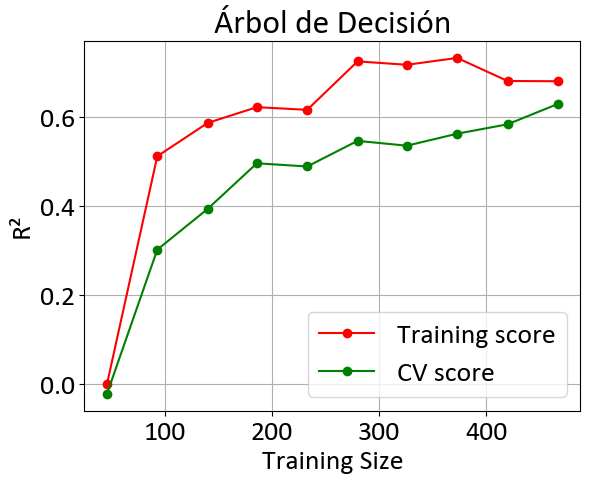

Learning curve saved as: DecisionTreeRegressor_Learning_Curve.png


In [62]:
# Learning curve
plot_learning_curve(best_dt, X_train, y_train, title="Árbol de Decisión")

In [63]:
results.append({
    'Modelo': 'Árbol_Decisión',
    'Test_R2': dt_test_r2,
    'Test_MSE': dt_test_mse,
    'Test_MAE': dt_test_mae,
    'Val_R2': dt_val_r2,
    'Val_MSE': dt_val_mse,
    'Val_MAE': dt_val_mae
})

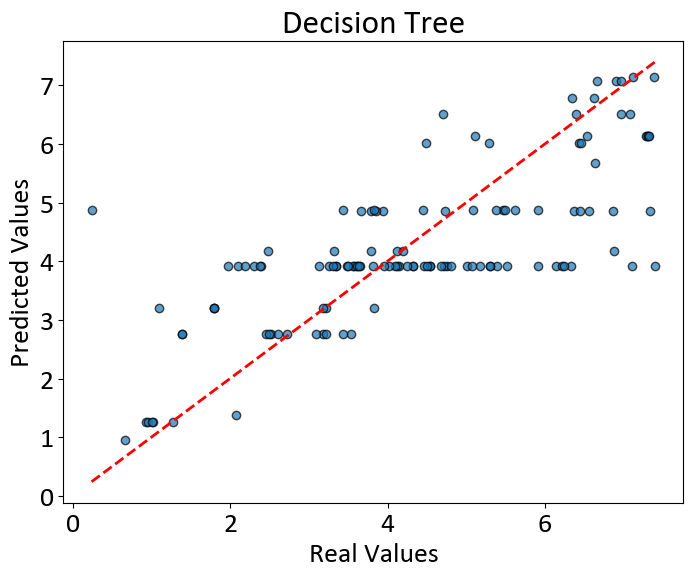

In [64]:
# -------------------------------
# 1. Predicted vs Actual
# -------------------------------
y_pred_test = best_dt.predict(X_test)

plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred_val, alpha=0.7, edgecolor='k')
# Ideal reference line (perfect prediction: y = x)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--', lw=2)
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("Decision Tree")
plt.savefig("figures/figure_10c.png", dpi=300, bbox_inches="tight") 
plt.show()

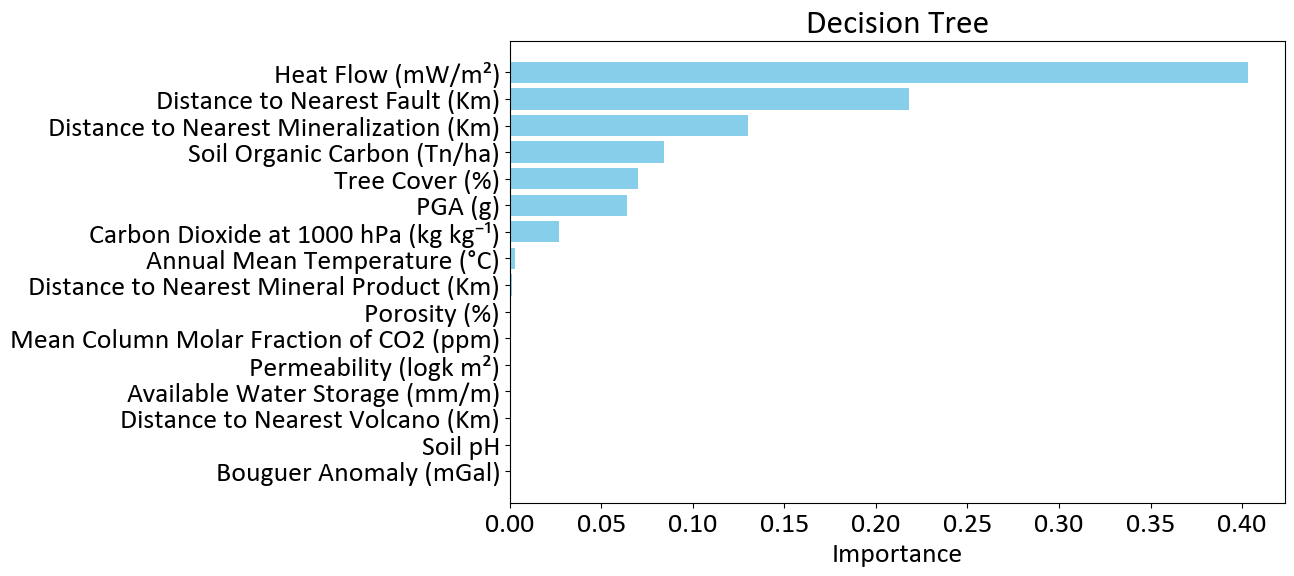

In [65]:
# -------------------------------
# 3. Feature Importance
# -------------------------------

importances = best_dt.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
features_sorted = np.array(features_preselected)[sorted_idx]

plt.figure(figsize=(10,6))
plt.barh(features_sorted, importances[sorted_idx], color="skyblue")
plt.gca().invert_yaxis()  # Ensure the most important feature appears at the top
plt.xlabel("Importance")
plt.title("Decision Tree")
plt.savefig("figures/figure_11c.png", dpi=300, bbox_inches="tight")  
plt.show()

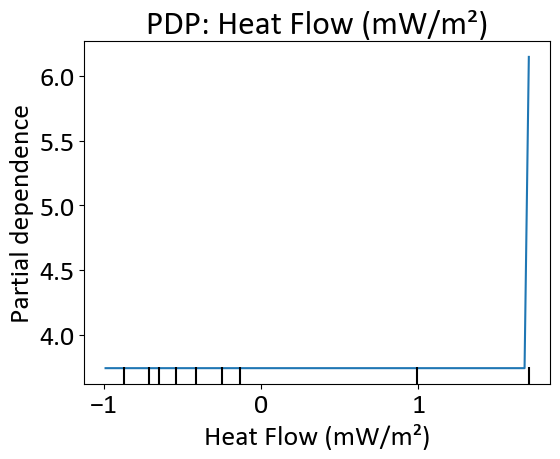

In [66]:
# -------------------------------
# 4. Partial Dependence Plot (PDP) for the most important variable
# -------------------------------

# Select the most important variable
first_feature = features_sorted[0]

fig, ax = plt.subplots(figsize=(6, 5)) 

# Plot the PDP for the most important feature
PartialDependenceDisplay.from_estimator(best_dt, X_train, [first_feature], ax=ax)

ax.set_title(f"PDP: {first_feature}")
plt.tight_layout()
#plt.savefig("DT_Partial_Dependence_FirstFeature.png", dpi=300, bbox_inches="tight")  # Adjusted dpi to 300

# Show the figure
plt.show()



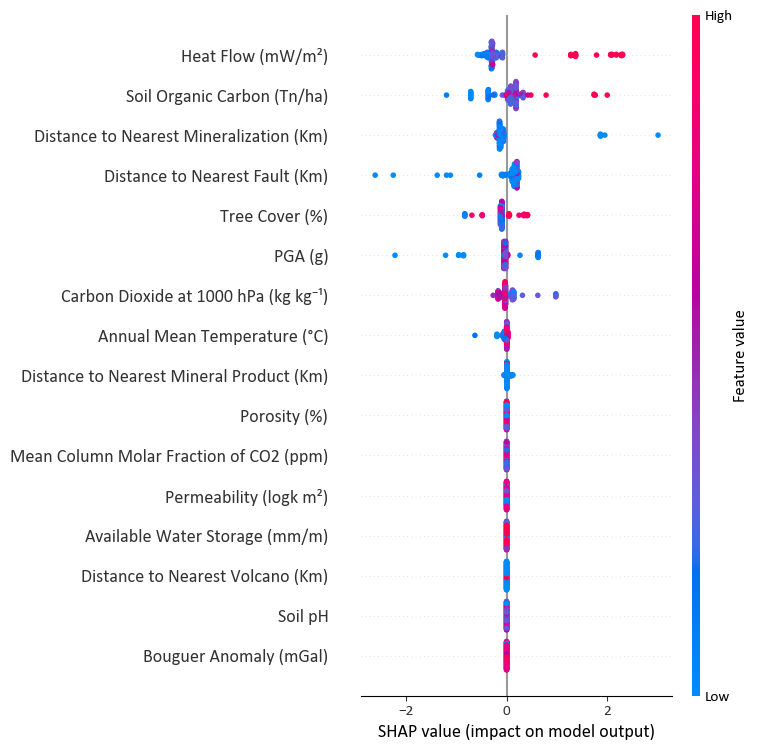

In [67]:
# -------------------------------
# 5. SHAP Summary with TreeExplainer
# -------------------------------

explainer = shap.TreeExplainer(best_dt)
shap_values = explainer.shap_values(X_val)

# Generate SHAP summary
plt.figure()
shap.summary_plot(shap_values, X_val, feature_names=features_preselected, show=False)

# Save the image before displaying it
plt.savefig("figures/figure_12c.png", dpi=300, bbox_inches="tight") 

# Show the image
plt.show()


## RANDOM FOREST

In [68]:
# -----------------------
# 4. Model: Random Forest
# -----------------------
print("\n=== Random Forest ===")
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400],      
    'max_depth': [None, 5, 10, 15, 20],        
    'min_samples_split': [2, 5, 10],           
    'min_samples_leaf': [1, 2, 4],             
    'bootstrap': [True, False]                 
}
grid_rf = GridSearchCV(rf, param_grid_rf, scoring='r2', cv=5, n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)
print("Mejores parámetros Random Forest:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_


=== Random Forest ===
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Mejores parámetros Random Forest: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 400}


In [69]:
# Evaluation in TEST
y_pred_test = best_rf.predict(X_test)
rf_test_r2 = r2_score(y_test, y_pred_test)
rf_test_mse = mean_squared_error(y_test, y_pred_test)
rf_test_mae = mean_absolute_error(y_test, y_pred_test)

In [70]:
# Evaluation in VALIDATION
y_pred_val = best_rf.predict(X_val)
rf_val_r2 = r2_score(y_val, y_pred_val)
rf_val_mse = mean_squared_error(y_val, y_pred_val)
rf_val_mae = mean_absolute_error(y_val, y_pred_val)

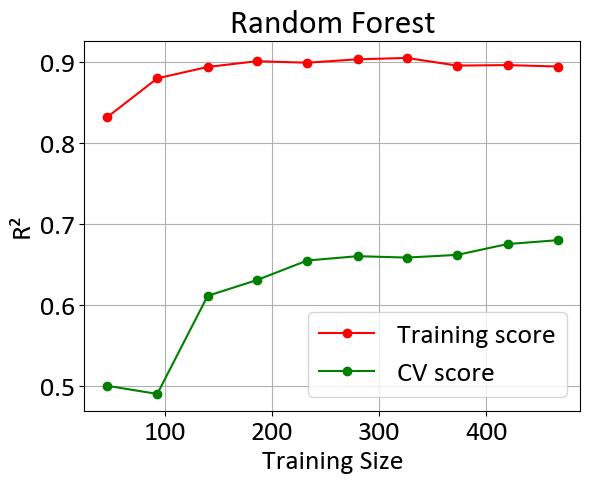

Learning curve saved as: RandomForestRegressor_Learning_Curve.png


In [71]:
# Learning curve
plot_learning_curve(best_rf, X_train, y_train, title="Random Forest")

In [72]:
results.append({
    'Modelo': 'Random_Forest',
    'Test_R2': rf_test_r2,
    'Test_MSE': rf_test_mse,
    'Test_MAE': rf_test_mae,
    'Val_R2': rf_val_r2,
    'Val_MSE': rf_val_mse,
    'Val_MAE': rf_val_mae
})

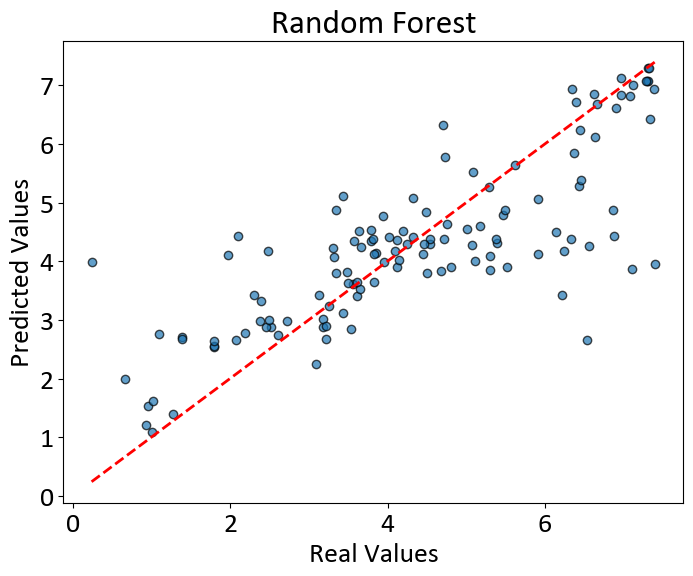

In [73]:
# -------------------------------
# 1. Predicted vs Actual Values
# -------------------------------

y_pred_test = best_rf.predict(X_val)

plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred_val, alpha=0.7, edgecolor='k')
# Ideal reference line (where actual values equal predicted values)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--', lw=2)
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest")
plt.savefig("figures/figure_10d.png", dpi=300, bbox_inches="tight") 
plt.show()


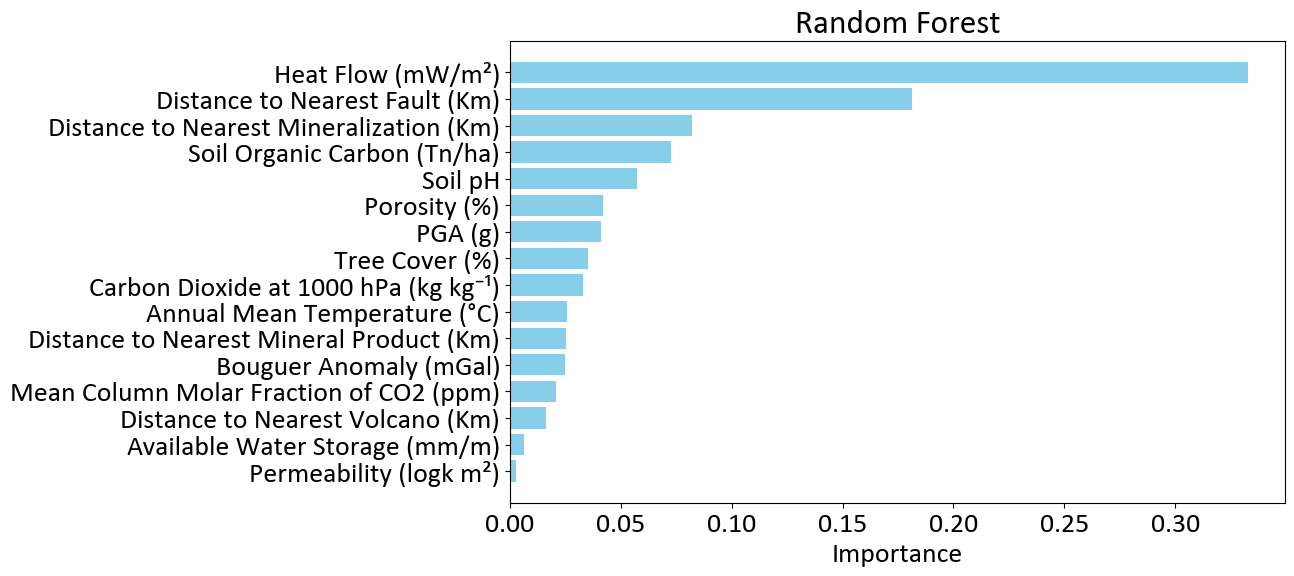

In [74]:
# -------------------------------
# 3. Feature Importance
# -------------------------------

importances = best_rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
features_sorted = np.array(features_preselected)[sorted_idx]

plt.figure(figsize=(10,6))
plt.barh(features_sorted, importances[sorted_idx], color="skyblue")
plt.gca().invert_yaxis()  # The most important feature will appear at the top
plt.xlabel("Importance")
plt.title("Random Forest")
plt.savefig("figures/figure_11d.png", dpi=300, bbox_inches="tight") 
plt.show()

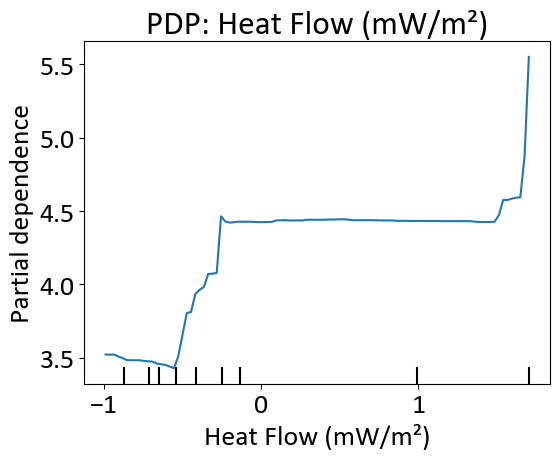

In [75]:
# -------------------------------
# 4. Partial Dependence Plot (PDP) for the most important variable
# -------------------------------

# Select the most important variable
first_feature = features_sorted[0]

fig, ax = plt.subplots(figsize=(6, 5))  
# Plot the PDP for the most important feature
PartialDependenceDisplay.from_estimator(best_rf, X_train, [first_feature], ax=ax)

ax.set_title(f"PDP: {first_feature}")
plt.tight_layout()
#plt.savefig("RF_Partial_Dependence_FirstFeature.png", dpi=300, bbox_inches="tight")  # Adjusted dpi to 300

# Show the figure
plt.show()


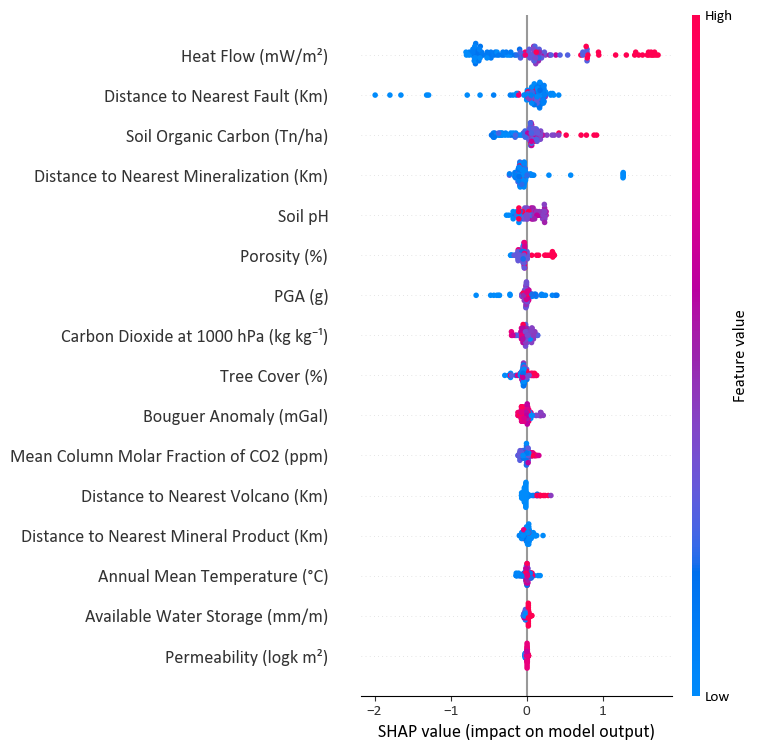

In [76]:
# -------------------------------
# 5. SHAP Summary with TreeExplainer
# -------------------------------
# For tree-based models, TreeExplainer is very efficient
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_val)

plt.figure()  # Create a new figure before plotting the SHAP graph
shap.summary_plot(shap_values, X_val, feature_names=features_preselected, show=False)

# Save the image before displaying it
plt.savefig("figures/figure_12d.png", dpi=300, bbox_inches="tight")  

# Show the image
plt.show()

## GRADIENT BOOSTING

In [77]:
# -----------------------
# 5. Model: Gradient Boosting (GBM)
# -----------------------
print("\n=== Gradient Boosting ===")
gbm = GradientBoostingRegressor(random_state=42)
param_grid_gbm = {
    'n_estimators': [100, 200, 300, 500], 
    'learning_rate': [0.001, 0.01, 0.1, 0.2],  
    'max_depth': [2, 3, 5, 7],           
    'subsample': [1.0, 0.8, 0.6],         
    'min_samples_split': [2, 5, 10]       
}
grid_gbm = GridSearchCV(gbm, param_grid_gbm, scoring='r2', cv=5, n_jobs=-1, verbose=1)
grid_gbm.fit(X_train, y_train)
print("Mejores parámetros Gradient Boosting:", grid_gbm.best_params_)
best_gbm = grid_gbm.best_estimator_


=== Gradient Boosting ===
Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Mejores parámetros Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 300, 'subsample': 0.6}


In [78]:
# Evaluation in TEST
y_pred_test = best_gbm.predict(X_test)
gbm_test_r2 = r2_score(y_test, y_pred_test)
gbm_test_mse = mean_squared_error(y_test, y_pred_test)
gbm_test_mae = mean_absolute_error(y_test, y_pred_test)

# Evaluation in VALIDATION
y_pred_val = best_gbm.predict(X_val)
gbm_val_r2 = r2_score(y_val, y_pred_val)
gbm_val_mse = mean_squared_error(y_val, y_pred_val)
gbm_val_mae = mean_absolute_error(y_val, y_pred_val)

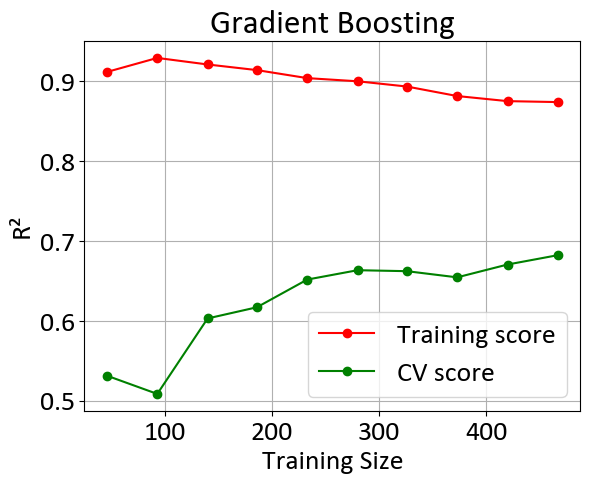

Learning curve saved as: GradientBoostingRegressor_Learning_Curve.png


In [79]:
# Learning curve
plot_learning_curve(best_gbm, X_train, y_train, title="Gradient Boosting")

In [80]:
results.append({
    'Modelo': 'Gradient_Boosting',
    'Test_R2': gbm_test_r2,
    'Test_MSE': gbm_test_mse,
    'Test_MAE': gbm_test_mae,
    'Val_R2': gbm_val_r2,
    'Val_MSE': gbm_val_mse,
    'Val_MAE': gbm_val_mae
})

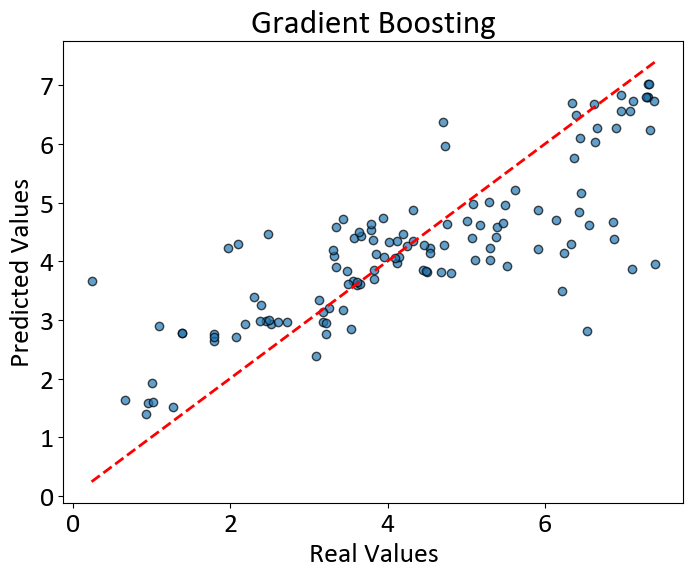

In [81]:
# -------------------------------
# 1. Predicted vs Actual Values
# -------------------------------
y_pred_test = best_gbm.predict(X_test)

plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred_val, alpha=0.7, edgecolor='k')
# Ideal reference line (where actual values equal predicted values)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--', lw=2)
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("Gradient Boosting")
plt.savefig("figures/figure_10e.png", dpi=300, bbox_inches="tight")
plt.show()


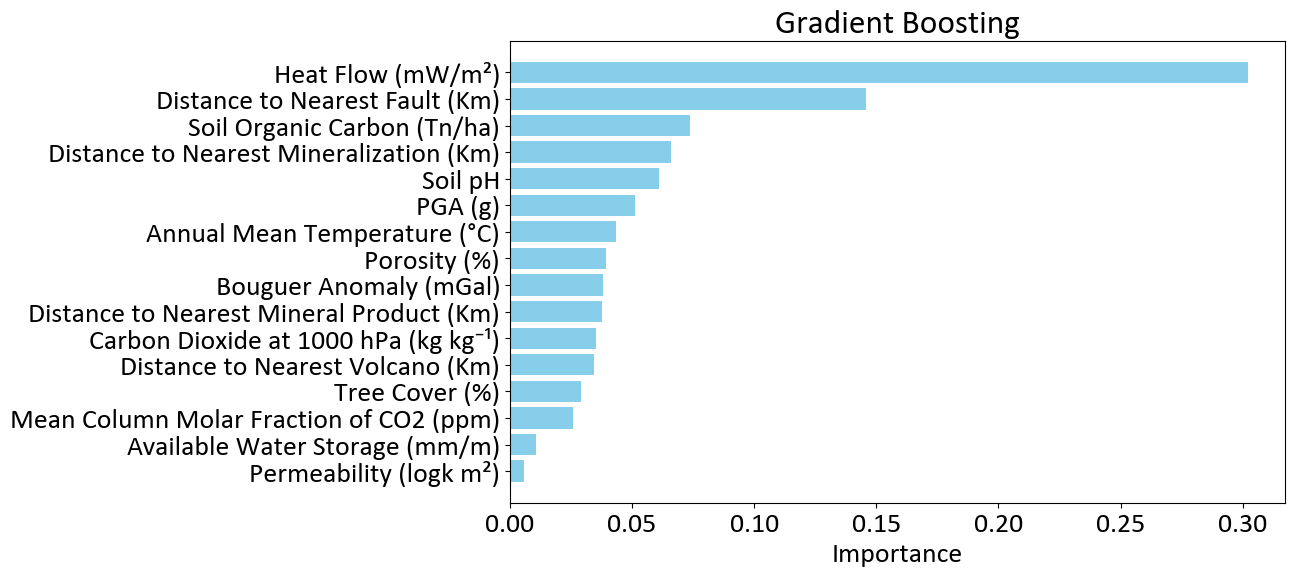

In [82]:
# -------------------------------
# 3. Feature Importance
# -------------------------------

importances = best_gbm.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
features_sorted = np.array(features_preselected)[sorted_idx]

plt.figure(figsize=(10,6))
plt.barh(features_sorted, importances[sorted_idx], color="skyblue")
plt.gca().invert_yaxis()  # The most important feature will appear at the top
plt.xlabel("Importance")
plt.title("Gradient Boosting")
plt.savefig("figures/figure_11e.png", dpi=300, bbox_inches="tight")
plt.show()


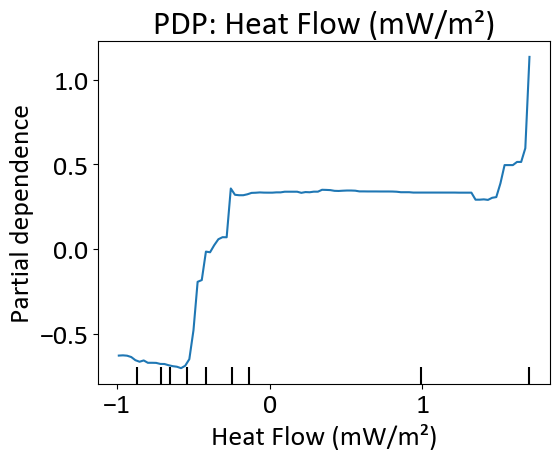

In [83]:
# -------------------------------
# 4. Partial Dependence Plot (PDP) for the most important variable
# -------------------------------

# Select the most important variable
first_feature = features_sorted[0]

fig, ax = plt.subplots(figsize=(6, 5)) 

# Plot the PDP for the most important feature
PartialDependenceDisplay.from_estimator(best_gbm, X_train, [first_feature], ax=ax)

ax.set_title(f"PDP: {first_feature}")
plt.tight_layout()
#plt.savefig("GBM_Partial_Dependence_FirstFeature.png", dpi=300, bbox_inches="tight")  # Adjusted dpi to 300

# Show the figure
plt.show()


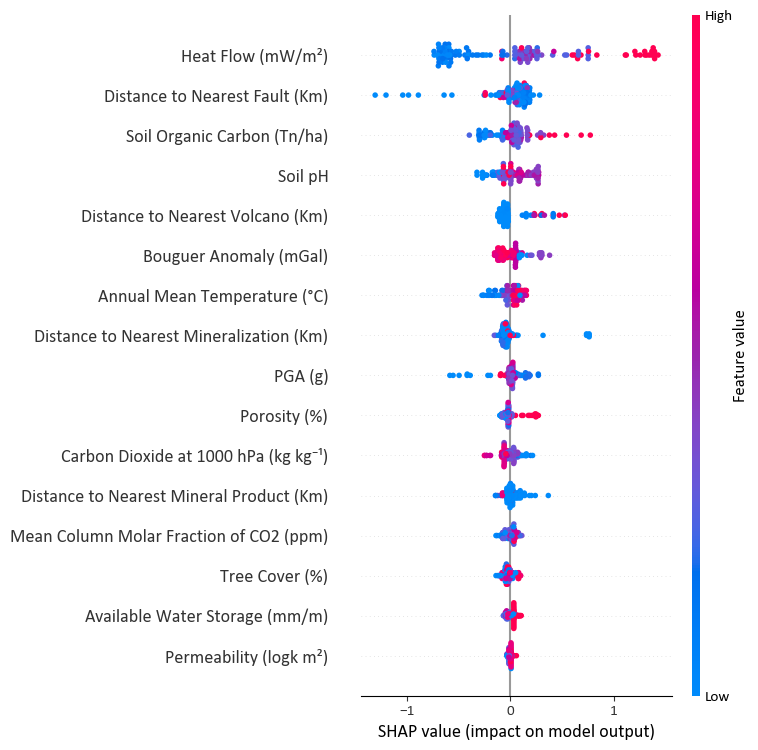

In [84]:
# -------------------------------
# 5. SHAP Summary with TreeExplainer
# -------------------------------
# TreeExplainer is efficient for tree-based models like Gradient Boosting
explainer = shap.TreeExplainer(best_gbm)
shap_values = explainer.shap_values(X_val)

# Generate SHAP summary
plt.figure()
shap.summary_plot(shap_values, X_val, feature_names=features_preselected, show=False)

plt.savefig("figures/figure_12e.png", dpi=300, bbox_inches="tight") 

# Show the image
plt.show()


## COMPARACIÓN GRÁFICA


Metrics Summary:
                    Test R2  Test MSE  Test MAE    Val R2   Val MSE   Val MAE
Modelo                                                                       
SVR Regressor      0.502375  1.332617  0.773536  0.494426  1.697087  0.927439
KNN Regressor      0.665281  0.896362  0.690231  0.611168  1.305213  0.814697
Árbol Decisión     0.487414  1.372681  0.854076  0.570506  1.441705  0.904066
Random Forest      0.645662  0.948902  0.673613  0.634906  1.225531  0.773441
Gradient Boosting  0.638008  0.969398  0.696171  0.634355  1.227380  0.806857


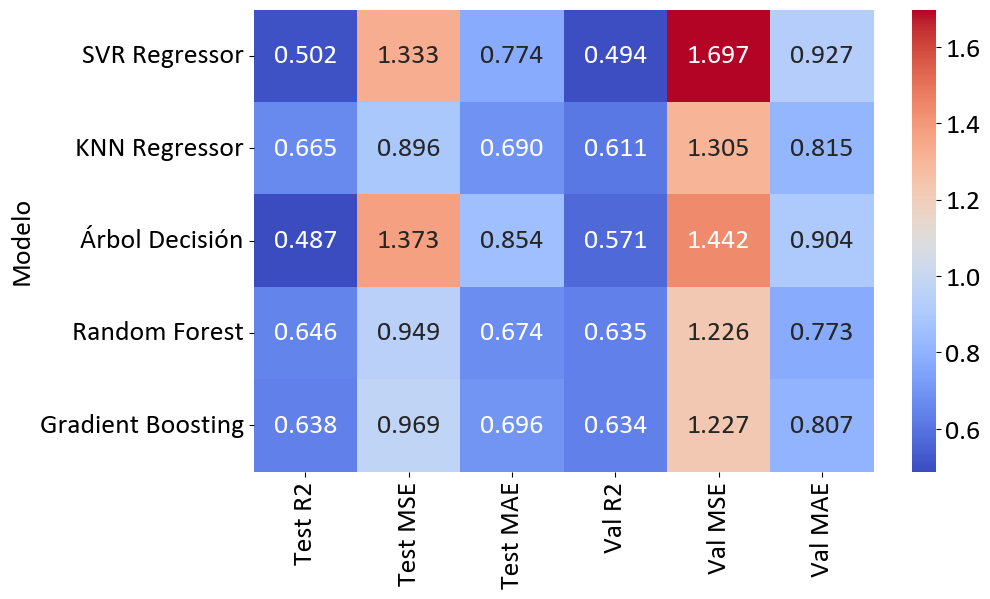

In [85]:
# -----------------------
# Graphical Comparison: Heatmap of Metrics
# -----------------------
results_df = pd.DataFrame(results).set_index('Modelo')
results_df.columns = results_df.columns.str.replace('_', ' ')
results_df.index = results_df.index.str.replace('_', ' ')

print("\nMetrics Summary:")
print(results_df)

# Since MSE and MAE values can vary in magnitude, it is common to normalize them or use an appropriate cmap.
plt.figure(figsize=(10, 6))
sns.heatmap(results_df, annot=True, fmt=".3f", cmap="coolwarm")
plt.savefig("figures/figure_9a.png", dpi=300, bbox_inches="tight")  # Adjusted dpi to 300
plt.show()


# Stacking 

In [98]:
# --- Define the base models with more diversity ---
estimators = [
    ('svr', best_svr),         
    ('knn', best_knn),
    ('dt', best_dt),
    ('rf', best_rf),           
    ('gbm', best_gbm),         
    ('ridge', Ridge(alpha=1.0))  # Linear model for greater diversity
]

# --- Define the non-linear meta-stimulator ---
meta_estimator = XGBRegressor(objective='reg:squarederror', random_state=42)

# --- Create the Stacking Regressor with passthrough activated ---
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_estimator,
    cv=5,
    n_jobs=-1,
    passthrough=True
)

# --- Defining the search space for the meta-estimator ---
# We use the notation “final_estimator__” to set the hyperparameters of the meta-estimator
param_distributions = {
    'final_estimator__n_estimators': randint(50, 300),
    'final_estimator__max_depth': randint(3, 10),
    'final_estimator__learning_rate': uniform(0.01, 0.2),
    'final_estimator__subsample': uniform(0.6, 0.4)  # valores entre 0.6 y 1.0
}

# --- Perform search with RandomizedSearchCV ---
random_search = RandomizedSearchCV(
    estimator=stacking_model,
    param_distributions=param_distributions,
    n_iter=30,          
    scoring='r2',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)

print("Best parameters found in the Stacking Regressor:")
print(random_search.best_params_)

# Extracting the best stacking model
best_stacking = random_search.best_estimator_

# --- Evaluation of the robust stacking model ---

# Evaluation in TEST
y_pred_test_stack = best_stacking.predict(X_test)
stack_r2_test = r2_score(y_test, y_pred_test_stack)
stack_mse_test = mean_squared_error(y_test, y_pred_test_stack)
stack_mae_test = mean_absolute_error(y_test, y_pred_test_stack)

print("\nStacking Regressor - Metrics in Test:")
print("R²:", stack_r2_test)
print("MSE:", stack_mse_test)
print("MAE:", stack_mae_test)

# Evaluation in VALIDATION
y_pred_val_stack = best_stacking.predict(X_val)
stack_r2_val = r2_score(y_val, y_pred_val_stack)
stack_mse_val = mean_squared_error(y_val, y_pred_val_stack)
stack_mae_val = mean_absolute_error(y_val, y_pred_val_stack)

print("\nStacking Regressor - Metrics in Validation:")
print("R²:", stack_r2_val)
print("MSE:", stack_mse_val)
print("MAE:", stack_mae_val)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found in the Stacking Regressor:
{'final_estimator__learning_rate': np.float64(0.021616722433639893), 'final_estimator__max_depth': 7, 'final_estimator__n_estimators': 149, 'final_estimator__subsample': np.float64(0.6571467271687763)}

Stacking Regressor - Metrics in Test:
R²: 0.6782390184594258
MSE: 0.8616611596407162
MAE: 0.6657494560697633

Stacking Regressor - Metrics in Validation:
R²: 0.6626367146395755
MSE: 1.1324455089912728
MAE: 0.7665606686456984



Stacking Regressor Metrics Summary:
         Test  Validation
R²   0.678239    0.662637
MSE  0.861661    1.132446
MAE  0.665749    0.766561


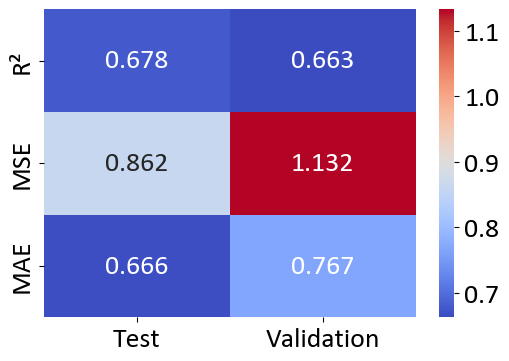

In [99]:
# Create a dictionary with evaluation metrics
metrics_data = {
    "Test": {
        "R²": stack_r2_test,
        "MSE": stack_mse_test,
        "MAE": stack_mae_test
    },
    "Validation": {
        "R²": stack_r2_val,
        "MSE": stack_mse_val,
        "MAE": stack_mae_val
    }
}

# Convert the dictionary into a DataFrame
df_metrics = pd.DataFrame(metrics_data)

# Display the metrics DataFrame
print("\nStacking Regressor Metrics Summary:")
print(df_metrics)

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df_metrics, annot=True, fmt=".3f", cmap="coolwarm")
plt.savefig("figures/figure_9b.png", dpi=300, bbox_inches="tight")  # Adjusted dpi to 300
plt.show()


In [100]:
# We reverse the logarithmic transformation 
y_pred_test_orig = np.exp(y_pred_val) - 1
y_test_orig = np.exp(y_val) - 1

# Recalculate metrics in the original scale (gm-2d-1)
mse_orig = mean_squared_error(y_test_orig, y_pred_test_orig)
mae_orig = mean_absolute_error(y_test_orig, y_pred_test_orig)

print("MSE in original Test units (gm-2d-1):", mse_orig)
print("MAE in original Test units (gm-2d-1):", mae_orig)

MSE in original Test units (gm-2d-1): 97452.3933533807
MAE in original Test units (gm-2d-1): 162.7978700491491


In [101]:
# Supongamos que y_pred_test son las predicciones en escala logarítmica y y_test son los valores reales (log transformados)
y_pred_test_orig = np.exp(y_pred_val) - 1
y_test_orig = np.exp(y_val) - 1

# Recalcular las métricas en la escala original (gm-2d-1)
mse_orig = mean_squared_error(y_test_orig, y_pred_test_orig)
mae_orig = mean_absolute_error(y_test_orig, y_pred_test_orig)

print("MSE in original Validation units (gm-2d-1):", mse_orig)
print("MAE in original Validation (gm-2d-1):", mae_orig)

MSE in original Validation units (gm-2d-1): 97452.3933533807
MAE in original Validation (gm-2d-1): 162.7978700491491


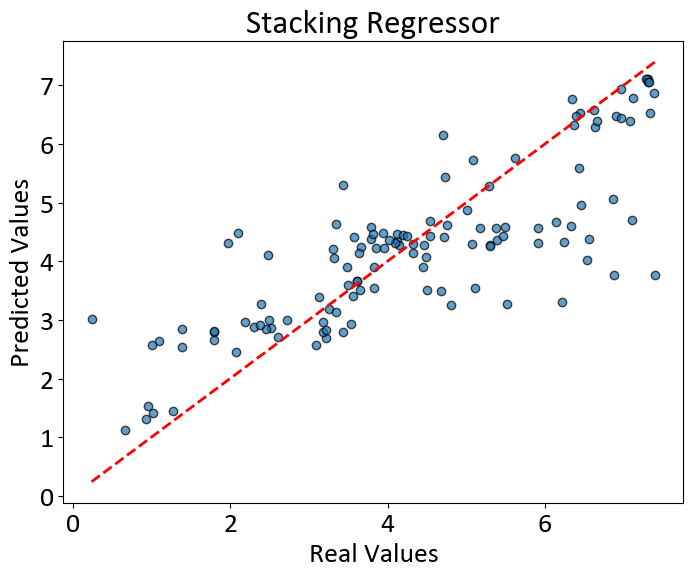

In [90]:
# Predicted vs Actual
y_pred_test_stack = best_stacking.predict(X_val)
plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred_val_stack, alpha=0.7, edgecolor='k')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--', lw=2)
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("Stacking Regressor")
plt.savefig("figures/figure_10f.png", dpi=300, bbox_inches="tight") 
plt.show()


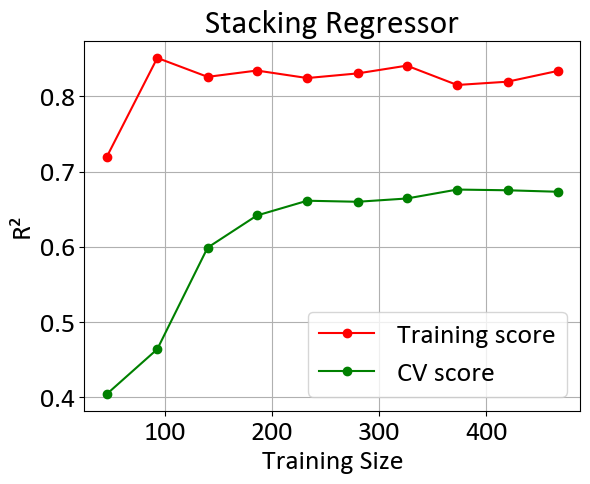

Learning curve saved as: StackingRegressor_Learning_Curve.png


In [91]:
plot_learning_curve(best_stacking, X_train, y_train, title="Stacking Regressor")

### Importancia de Características del Meta-Estimador

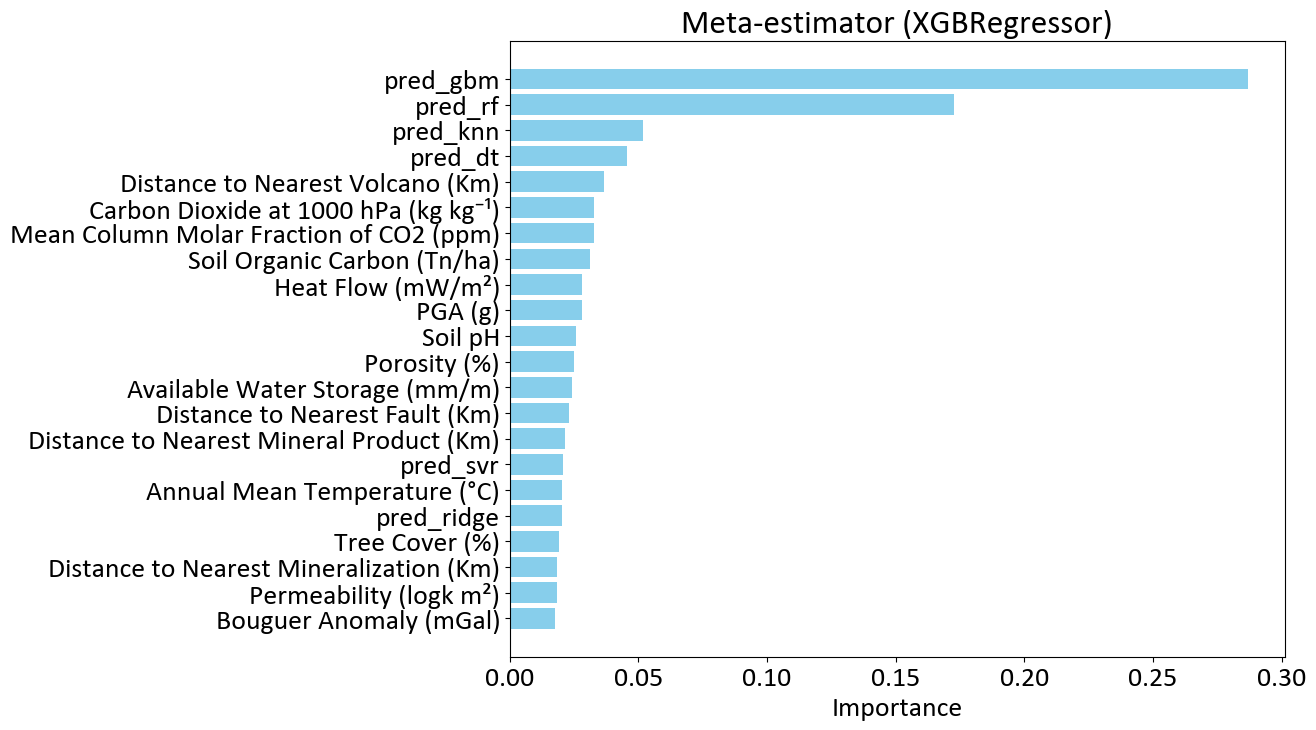

In [92]:
# Build names for the meta-estimator features
# First: the predictions of each base model
meta_base_names = [f"pred_{name}" for name, _ in estimators]
# Then: the original features (passthrough)
meta_feature_names = meta_base_names + features_preselected

# Extract feature importances from the meta-estimator
meta_importances = best_stacking.final_estimator_.feature_importances_
sorted_idx = np.argsort(meta_importances)[::-1]

plt.figure(figsize=(10,8))
plt.barh(np.array(meta_feature_names)[sorted_idx], meta_importances[sorted_idx], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Meta-estimator (XGBRegressor)")
plt.savefig("figures/figure_11f.png", dpi=300, bbox_inches="tight") 
plt.show()


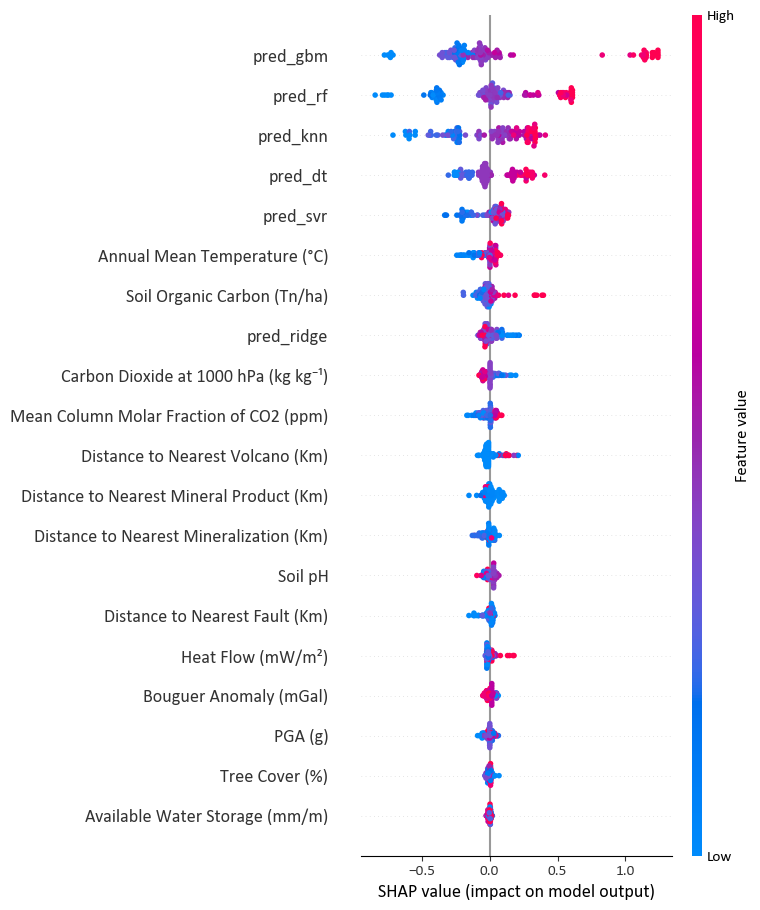

In [94]:
import shap

# Get the meta-features matrix from the test set
meta_features = best_stacking.transform(X_val)

# Create a TreeExplainer for the meta-estimator
explainer_meta = shap.TreeExplainer(best_stacking.final_estimator_)
shap_values_meta = explainer_meta.shap_values(meta_features)

# Generate SHAP summary using the defined feature names
plt.figure()
shap.summary_plot(shap_values_meta, meta_features, feature_names=meta_feature_names, show=False)

# Save the image before displaying it
plt.savefig("figures/figure_12f.png", dpi=300, bbox_inches="tight")  # Adjusted dpi to 300

# Show the image
plt.show()


### Cargando Nuevo DataFrame Tamburello et al. (2018)

In [122]:
# ------------------------------
# 1. Load the new database
# ------------------------------
file_path = "data/CO2_Flux_model_Tamburello_new.csv"
new_data = pd.read_csv(file_path)

In [123]:
# ------------------------------
# 2. Column renaming in two steps
# ------------------------------
# Step 1: Renaming of raw names 
rename = {
    'Bouguer_Anomaly_mGal': 'Bouguer Anomaly (mGal)',
    'Heat_Flow_mW_m2': 'Heat Flow (mW/m²)',
    'Annual_Mean_Temperature_C': 'Annual Mean Temperature (°C)',
    'Soil_Organic_Carbon_ton_ha': 'Soil Organic Carbon (Tn/ha)',
    'Soil_pH_H2O': 'Soil pH',
    'faults_distance_km': 'Distance to Nearest Fault (Km)',
    'mineralization_distance_km': 'Distance to Nearest Mineralization (Km)',
    'volcano_distance_km': 'Distance to Nearest Volcano (Km)',
    'mineral_commodity_distance_km': 'Distance to Nearest Mineral Product (Km)',
    'Available_Water_Storage_mm_m': 'Available Water Storage (mm/m)',
    'Tree_Cover_Percentage': 'Tree Cover (%)',
    'Porosity': 'Porosity (%)',
    'PGA_Mean': 'PGA (g)',
    'tcco2_column': 'Mean Column Molar Fraction of CO2 (ppm)',
    'nuevos1_co2_1000hPa': 'Carbon Dioxide at 1000 hPa (kg kg⁻¹)',
    'Permeability_permafrost': 'Permeability (logk m²)',
    'CO2_1000hPa': 'Carbon Dioxide at 1000 hPa (kg kg⁻¹)'
}
new_data = new_data.rename(columns=rename)

In [125]:
# ------------------------------
# 3. Transform Distance Columns
# ------------------------------
distance_cols = ['Distance to Nearest Fault (Km)',
                 'Distance to Nearest Mineralization (Km)',
                 'Distance to Nearest Volcano (Km)',
                 'Distance to Nearest Mineral Product (Km)']
small_value = 0.001  # For example, 10 meters

for col in distance_cols:
    new_data[col] = new_data[col].replace(0, small_value)
    new_data[col] = 1 / (new_data[col] ** 2)


In [126]:
reclassification = {1: "Normal", 2: "Strike-slip", 3: "Reverse", -1: "Strike-slip"}
if 'Slip_type_general_Id' in new_data.columns:
    new_data['Slip_type_general_Id'] = new_data['Slip_type_general_Id'].replace(reclassification)

In [127]:
# ------------------------------
# 5. Select the columns expected by the model
# ------------------------------
expected_features = [
    'Bouguer Anomaly (mGal)',
    'Heat Flow (mW/m²)',
    'Annual Mean Temperature (°C)',
    'Soil Organic Carbon (Tn/ha)',
    'Soil pH',
    'Distance to Nearest Fault (Km)',
    'Distance to Nearest Mineralization (Km)',
    'Distance to Nearest Volcano (Km)',
    'Distance to Nearest Mineral Product (Km)',
    'Available Water Storage (mm/m)',
    'Tree Cover (%)',
    'Porosity (%)',
    'Permeability (logk m²)',
    'PGA (g)',
    'Carbon Dioxide at 1000 hPa (kg kg⁻¹)',
    'Mean Column Molar Fraction of CO2 (ppm)'
]


In [128]:
# Keep the coordinates to combine them with the predictions
coords = new_data[['Longitude (x)', 'Latitude (y)']]

In [129]:
# Create a DataFrame for the model 
data_for_model = new_data.copy()
cols_to_drop = set(data_for_model.columns) - (set(expected_features) | {'Longitude (x)', 'Latitude (y)'})
data_for_model = data_for_model.drop(columns=cols_to_drop, errors='ignore')

In [130]:
# Check for missing columns that the model expects (printed for control)
missing_columns = set(expected_features) - set(data_for_model.columns)
print("Columnas que faltan en new_data:", missing_columns)
# Add the missing ones with value 0
for col in missing_columns:
    data_for_model[col] = 0

# Rearrange the columns according to the expected order
data_for_model = data_for_model[expected_features]

Columnas que faltan en new_data: set()


In [131]:
# ------------------------------
# 6. Imputation of missing values and scaling
# ------------------------------
# To avoid NaN, we fill in the missing values 
data_for_model = data_for_model.fillna(data_for_model.median())

# Data are scaled.
data_for_model_scaled = scaler.transform(data_for_model)

In [132]:
# ------------------------------
# 7. Making predictions with the final model (best_stacking)
# ------------------------------
#best_stacking' is the Stacking Regressor trained on the logarithmic variable.
predictions_log = best_stacking.predict(data_for_model_scaled)
# As the target variable was transformed with np.log(y+1), the inverse transformation is applied:
predictions = np.exp(predictions_log) - 1

In [133]:
# ------------------------------
# 8. Combine coordinates with predictions and visualize results
# ------------------------------
predictions_df = pd.DataFrame({'Predicted_Flux (gm-2d-1)': predictions})
final_predictions = pd.concat([coords.reset_index(drop=True), predictions_df], axis=1)

print("Predicciones (primeras filas):")
print(final_predictions.head())

Predicciones (primeras filas):
   Longitude (x)  Latitude (y)  Predicted_Flux (gm-2d-1)
0            6.8          36.6                 17.908632
1            7.7          35.2                 25.830502
2          -68.6         -30.7                 56.952171
3          -66.8         -22.6                 77.730057
4          -65.9         -34.8                 46.116589


In [134]:
# Guardar las predicciones en un archivo CSV
final_predictions.to_excel("data/Flux_Predicted_Tamburello.xlsx", index=False, sheet_name="Data_CO2_Flux")

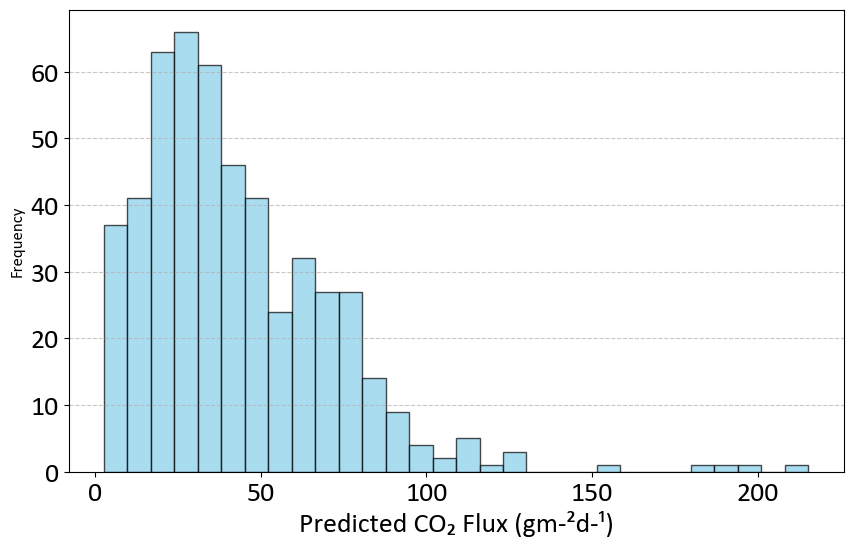

In [135]:
# Histogram of Predictions
plt.figure(figsize=(10, 6))
plt.hist(predictions, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
#plt.title("Distribution of Predicted CO₂ Flux", fontsize=14)
plt.xlabel("Predicted CO₂ Flux (gm-²d-¹)", fontsize=20)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("figures/figure_13b.png", dpi=300, bbox_inches="tight") 
plt.show()